In [2]:
# Load packages

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import geopandas
import descartes
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler
from main import *
from causal_sensitivity import *
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Data 

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
df['hiv_cases'] = df['hiv_rate']*df['population'] # In thousands
df.head(5)


,country,id,year,hiv_rate,hiv_aid,electricity,fertility,fdi,gdp_growth,gdp_per_cap_PPP,...,life_exp,maternal_mort,infant_mort,population,undernourishment,school_enr,unemployment,hiv_rate_lag,hiv_reduction,hiv_cases
2,Afghanistan,AFG,2017,0.04,5.816563,97.699997,4.633,51.533897,2.647003,2.058400,...,64.130,638.0,49.5,36.296111,23.0,1.021758,11.180,0.04,0.000000,1.451844
5,Albania,ALB,2017,0.04,0.018378,99.889999,1.638,1022.757857,3.802227,12.770964,...,78.333,15.0,8.4,2.873457,4.1,1.070466,13.620,0.04,0.000000,0.114938
8,Algeria,DZA,2017,0.04,1.231559,99.635490,3.045,1230.243451,1.300000,11.737401,...,76.499,112.0,20.9,41.389174,2.7,1.117645,10.333,0.04,0.000000,1.655567
11,Angola,AGO,2017,0.91,23.267460,43.013260,5.600,-7397.295409,-0.147213,7.310897,...,60.379,241.0,53.5,29.816769,15.4,1.072162,7.408,0.94,0.031915,27.133260
14,Argentina,ARG,2017,0.14,0.647892,100.000000,2.275,11516.861462,2.818503,23.597118,...,76.372,39.0,9.2,44.044811,3.1,1.097415,8.350,0.14,0.000000,6.166274


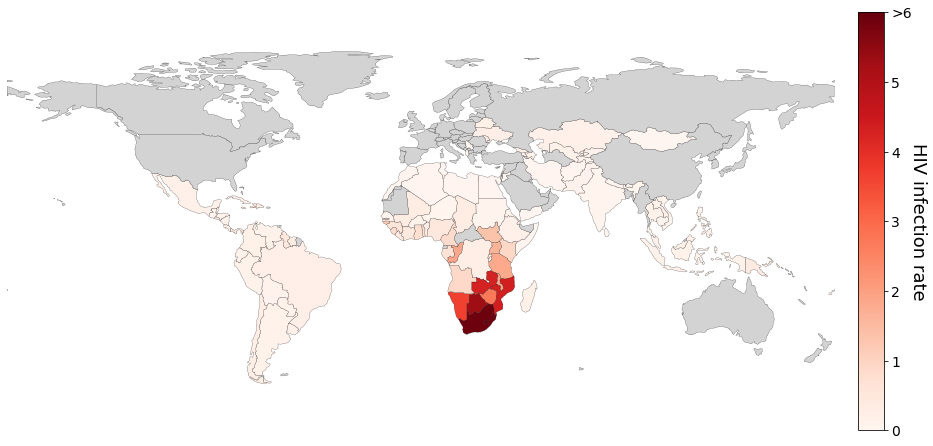

In [4]:
# Map HIV incidence rate 

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
map_data = world.merge(df, how="left", left_on=['iso_a3'], right_on=['id'])
map_data.head(5)

plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

orig_map=plt.cm.get_cmap('Reds')
reversed_map = orig_map.reversed()

f,ax = plt.subplots(figsize=(16,10),facecolor = 'white')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

plot = map_data.plot(column='hiv_rate', 
            ax=ax,
            cax=cax,
            cmap=orig_map,       
            edgecolor='black',
            linewidth=0.2,
            legend=True,
            legend_kwds={'ticks': [0,1,2,3,4,5,6]},
            vmin=0,
            vmax=6,
            missing_kwds={
                "color": "lightgrey"
              })

cax.set_yticklabels(['0','1','2','3','4','5','>6'])
cax.set_ylabel('HIV infection rate', rotation=270, labelpad=15)

ax.set_xlim([-180, 180])
ax.set_ylim([-75, 100])
ax.set_axis_off()

fig = plot.get_figure()
# fig.savefig("HIV_infection_map.pdf", bbox_inches='tight')


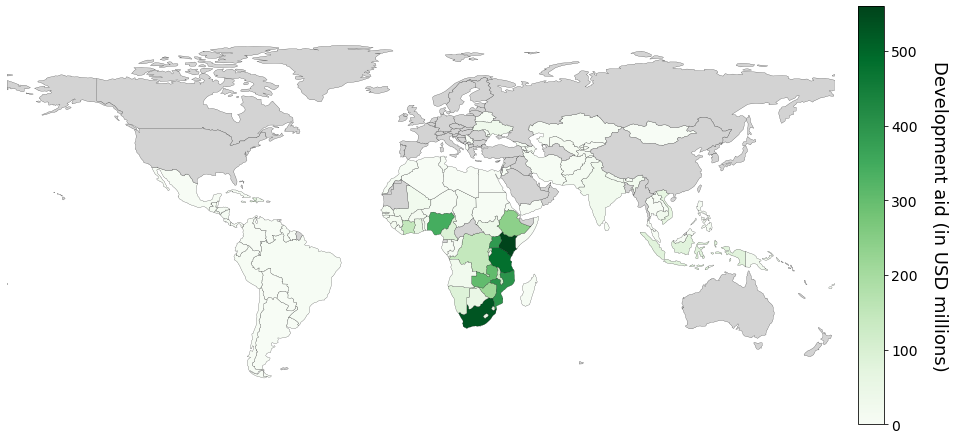

In [7]:
# Map HIV development aid

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
map_data = world.merge(df, how="left", left_on=['iso_a3'], right_on=['id'])
map_data.head(5)

plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

orig_map=plt.cm.get_cmap('Greens')
reversed_map = orig_map.reversed()

f,ax = plt.subplots(figsize=(16,10),facecolor = 'white')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)


plot = map_data.plot(column='hiv_aid', 
            ax=ax,
            cax=cax,
            cmap=orig_map,       
            edgecolor='black',
            linewidth=0.2,
            legend=True,
            legend_kwds={'label': "Development aid (in millions USD)"},
            vmin=0,
            missing_kwds={
                "color": "lightgrey",
              })

cax.set_ylabel('Development aid (in USD millions)', rotation=270, labelpad=30)

plot.axes.xaxis.set_visible(False)
plot.axes.yaxis.set_visible(False)
ax.set_xlim([-180, 180])
ax.set_ylim([-75, 100])
ax.set_axis_off()

fig = plot.get_figure()
# fig.savefig("HIV_aid_map.pdf", bbox_inches='tight')


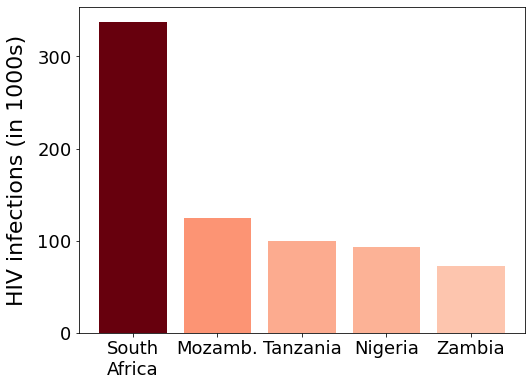

In [12]:
# Barplot: number of cases

fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

df_cases = df.loc[:, ['country', 'hiv_cases']]
df_cases = df_cases.sort_values(by='hiv_cases', ascending=False)
cases = df_cases['hiv_cases'][0:5]
countries = df_cases['country'][0:5]
countries.iloc[0] = 'South\nAfrica'
countries.iloc[1] = 'Mozamb.'

data_color = cases
data_color_normalized = [x / max(data_color) for x in data_color]
my_cmap = plt.cm.get_cmap('Reds')
colors = my_cmap(data_color_normalized)

ax.bar(countries, cases, color=colors)
ax.set_ylabel('HIV infections (in 1000s)', labelpad=10)
ax.set_yticks([0,100,200,300])
ax.set_yticklabels(['0','100','200','300'])
ax.set_title("")

# fig.savefig("HIV_cases.pdf", bbox_inches='tight')


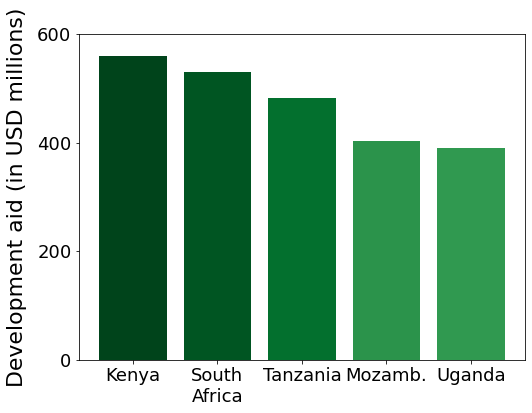

In [14]:
# Barplot: aid recipients

fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(8)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

df_cases = df.loc[:, ['country', 'hiv_aid']]
df_cases = df_cases.sort_values(by='hiv_aid', ascending=False)
cases = df_cases['hiv_aid'][0:5]
countries = df_cases['country'][0:5]
countries.iloc[1] = 'South\nAfrica'
countries.iloc[3] = 'Mozamb.'

data_color = cases
data_color_normalized = [x / max(data_color) for x in data_color]
my_cmap = plt.cm.get_cmap('Greens')
colors = my_cmap(data_color_normalized)

ax.bar(countries, cases, color=colors)
ax.set_ylabel('Development aid (in USD millions)', labelpad=10)
ax.set_yticks([0,200,400,600])
ax.set_yticklabels(['0','200','400','600'])
ax.set_title("")

# fig.savefig("aid_recipients.pdf", bbox_inches='tight')


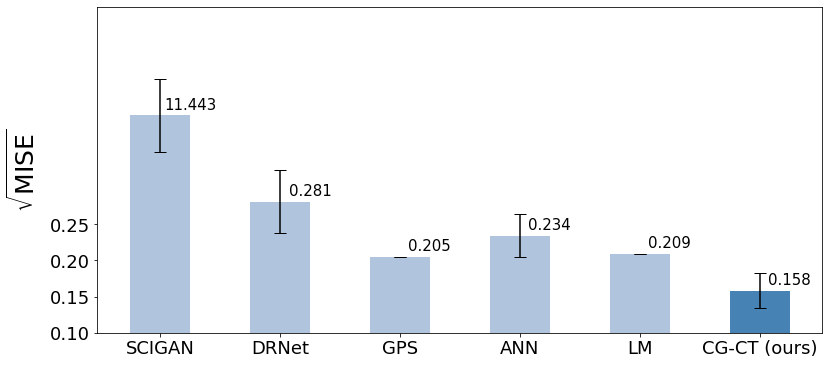

In [16]:
# Results: semi-synthetic

fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(13)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

results = [.4, .281, .205, .234, .209, .158]
sd = [0.05, .043, .000, .03, .000, .024]
models = ['SCIGAN', 'DRNet', 'GPS', 'ANN', 'LM', 'CG-CT (ours)']

pps = ax.bar(models, height=results, yerr=sd, align='center', ecolor='black', capsize=6, 
             width=0.5, color=['lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue',
                                                 'lightsteelblue', 'steelblue'])
for i,p in enumerate(pps):
    if i == 0:
        height = p.get_height()
        ax.annotate('{}'.format(11.443),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(30, 3), 
            textcoords="offset points",
            ha='center', va='bottom', size=15)
    if i > 0:
        height = p.get_height()
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(30, 3), 
            textcoords="offset points",
            ha='center', va='bottom', size=15)
    
ax.set_ylabel('$\sqrt{\mathrm{MISE}}$', labelpad=10, size=25)
ax.set_ylim([0.1, 0.55])
ax.set_yticks([0.1, 0.15, 0.2, 0.25])
ax.set_title("")

# fig.savefig("res_semi_syn.pdf", bbox_inches='tight')


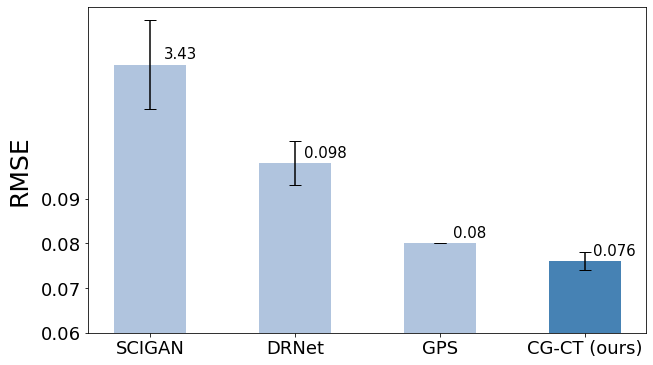

In [18]:
# Results: real-world

fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
    
results = [.12, .098, .080, .076]
sd = [0.01, .005, .000, .002]
models = ['SCIGAN', 'DRNet', 'GPS', 'CG-CT (ours)']

data_color = results
data_color_normalized = [x / max(data_color) for x in data_color]
my_cmap = plt.cm.get_cmap('Blues')
colors = my_cmap(data_color_normalized)

pps = ax.bar(models, height=results, yerr=sd, align='center', ecolor='black', capsize=6, 
             width=0.5, color=['lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'steelblue'])
for i,p in enumerate(pps):
    if i == 0:
        height = p.get_height()
        ax.annotate('{}'.format(3.430),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(30, 3), 
            textcoords="offset points",
            ha='center', va='bottom', size=15)
    if i > 0:
        height = p.get_height()
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(30, 3), 
            textcoords="offset points",
            ha='center', va='bottom', size=15)
    
ax.set_ylabel('RMSE', labelpad=10, size=25)
ax.set_ylim([0.06, 0.133])
ax.set_yticks([0.06, 0.07, 0.08, 0.09])
ax.set_title("")

# fig.savefig("res_real_world.pdf", bbox_inches='tight')


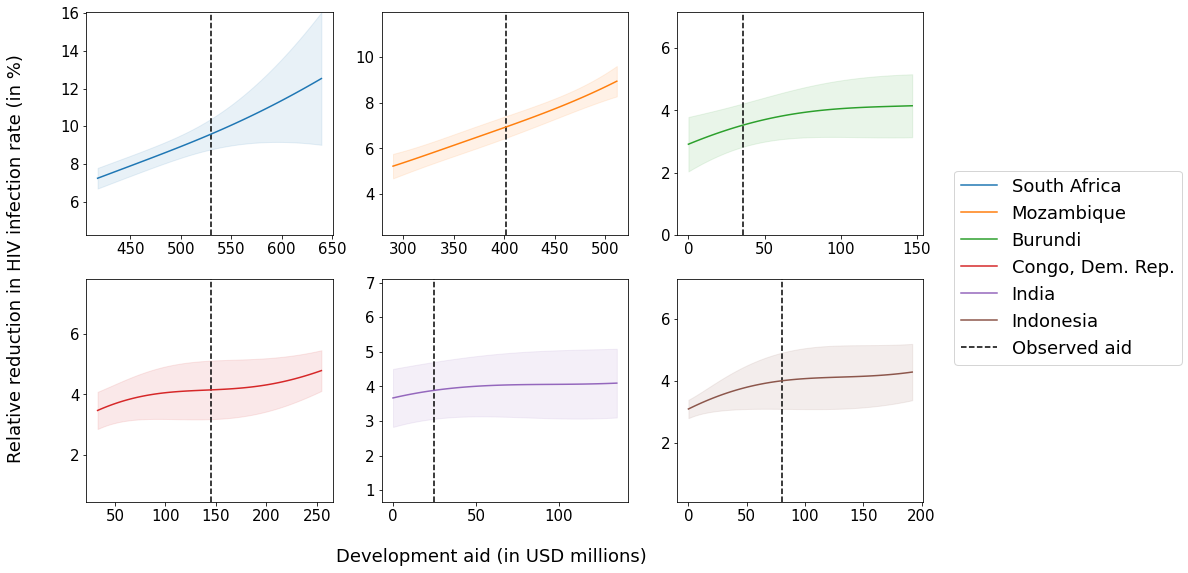

In [20]:
# Plot treatment response curves for example countries

a_sig = np.std(df['hiv_aid'])
GPS_mods = np.load('plot_data/tr_var.npz')
b_coef = GPS_mods['b_coef']
sig_hat = GPS_mods['sig_hat']
a_coef = GPS_mods['a_coef']
df_baes = GPS_mods['df_bae']

fig, axs = plt.subplots(2, 3)
fig.set_figheight(9)
fig.set_figwidth(15)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18) 
color_cycle = plt.rcParams['axes.prop_cycle']()

countries = ['South Africa', 'Mozambique', 'Burundi', 'Congo, Dem. Rep.', 'India', 'Indonesia']

# Country 1
country = countries[0]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
tr_curves = np.empty((len(a),10))
y = np.empty(len(a))
ci = np.empty(len(a))
for i in range(len(a)):
    for j in range(10):
        country_ind = np.where(df['country'] == country)[0]
        tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j:(j+1)], sig_hat[:,j:(j+1)], a_coef[:,j:(j+1)])*100
    y[i] = tr_curves[i,0]
    ci[i] = np.std(tr_curves, axis=1)[i]
axs[0,0].plot(a, y, label=country, **next(color_cycle))
axs[0,0].fill_between(a, (y-ci), (y+ci), color='tab:blue', alpha=.1)
y_min = y.min() - 3
if y_min < 0:
    y_min = 0
y_max = y.max() + 3.5
axs[0,0].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                colors='black', linestyle='dashed')
axs[0,0].set_ylim([y_min, y_max])

# Country 2
country = countries[1]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
tr_curves = np.empty((len(a),10))
y = np.empty(len(a))
ci = np.empty(len(a))
for i in range(len(a)):
    for j in range(10):
        country_ind = np.where(df['country'] == country)[0]
        tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
    y[i] = tr_curves[i,0]
    ci[i] = np.std(tr_curves, axis=1)[i] 
axs[0,1].plot(a, y, label=country, **next(color_cycle))
axs[0,1].fill_between(a, (y-ci), (y+ci), color='tab:orange', alpha=.1)
y_min = y.min() - 3
if y_min < 0:
    y_min = 0
y_max = y.max() + 3
axs[0,1].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                colors='black', linestyle='dashed')
axs[0,1].set_ylim([y_min, y_max])

# Country 3
country = countries[2]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs-a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
tr_curves = np.empty((len(a),10))
y = np.empty(len(a))
ci = np.empty(len(a))
for i in range(len(a)):
    for j in range(10):
        country_ind = np.where(df['country'] == country)[0]
        tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
    y[i] = tr_curves[i,0]
    ci[i] = np.std(tr_curves, axis=1)[i] 
axs[0,2].plot(a, y, label=country, **next(color_cycle))
axs[0,2].fill_between(a, (y-ci), (y+ci), color='tab:green', alpha=.1)
y_min = y.min() - 3
if y_min < 0:
    y_min = 0
y_max = y.max() + 3
axs[0,2].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                colors='black', linestyle='dashed')
axs[0,2].set_ylim([y_min, y_max])

# Country 4
country = countries[3]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
tr_curves = np.empty((len(a),10))
y = np.empty(len(a))
ci = np.empty(len(a))
for i in range(len(a)):
    for j in range(10):
        country_ind = np.where(df['country'] == country)[0]
        tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
    y[i] = tr_curves[i,0]
    ci[i] = np.std(tr_curves, axis=1)[i] 
axs[1,0].plot(a, y, label=country, **next(color_cycle))
axs[1,0].fill_between(a, (y-ci), (y+ci), color='tab:red', alpha=.1)
y_min = y.min() - 3
if y_min < 0:
    y_min = 0
y_max = y.max() + 3
axs[1,0].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                colors='black', linestyle='dashed')
axs[1,0].set_ylim([y_min, y_max])

# Country 5
country = countries[4]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
tr_curves = np.empty((len(a),10))
y = np.empty(len(a))
ci = np.empty(len(a))
for i in range(len(a)):
    for j in range(10):
        country_ind = np.where(df['country'] == country)[0]
        tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
    y[i] = tr_curves[i,0]
    ci[i] = np.std(tr_curves, axis=1)[i] 
axs[1,1].plot(a, y, label=country, **next(color_cycle))
axs[1,1].fill_between(a, (y-ci), (y+ci), color='tab:purple', alpha=.1)
y_min = y.min() - 3
if y_min < 0:
    y_min = 0
y_max = y.max() + 3
axs[1,1].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                colors='black', linestyle='dashed')
axs[1,1].set_ylim([y_min, y_max])

# Country 6
country = countries[5]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
tr_curves = np.empty((len(a),10))
y = np.empty(len(a))
ci = np.empty(len(a))
for i in range(len(a)):
    for j in range(10):
        country_ind = np.where(df['country'] == country)[0]
        tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
    y[i] = tr_curves[i,0]
    ci[i] = np.std(tr_curves, axis=1)[i] 
axs[1,2].plot(a, y, label=country, **next(color_cycle))
axs[1,2].fill_between(a, (y-ci), (y+ci), color='tab:brown', alpha=.1)
y_min = y.min() - 3
if y_min < 0:
    y_min = 0
y_max = y.max() + 3
axs[1,2].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max, 
                colors='black', linestyle='dashed', label='Observed aid')
axs[1,2].set_ylim([y_min, y_max])

fig.text(0.5, 0.04, 'Development aid (in USD millions)', ha='center', va='center', size=18)
fig.text(0.06, 0.5, "Relative reduction in HIV infection rate (in %)", ha='center', va='center', rotation='vertical', size=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.92, 0.65), loc='upper left')

# plt.savefig("aid_response_curves.pdf", bbox_inches='tight')


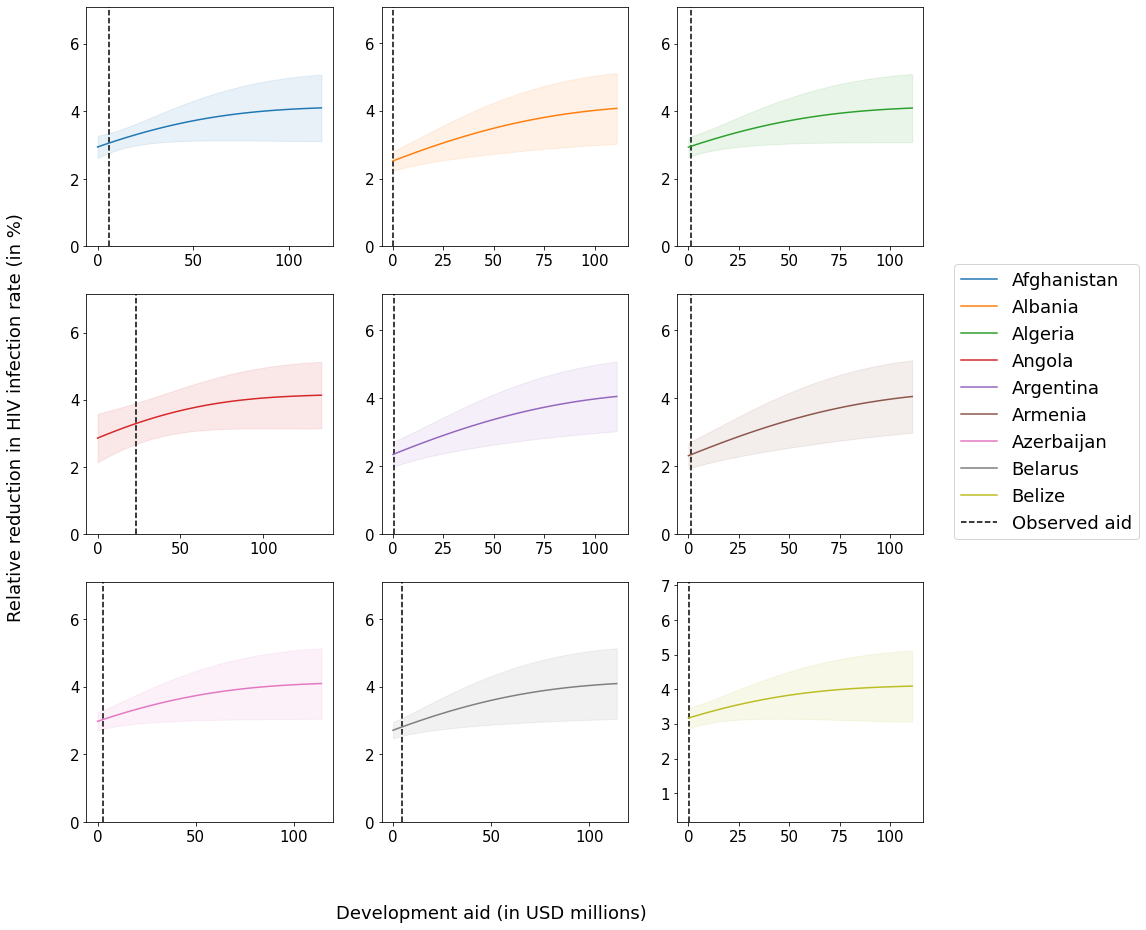

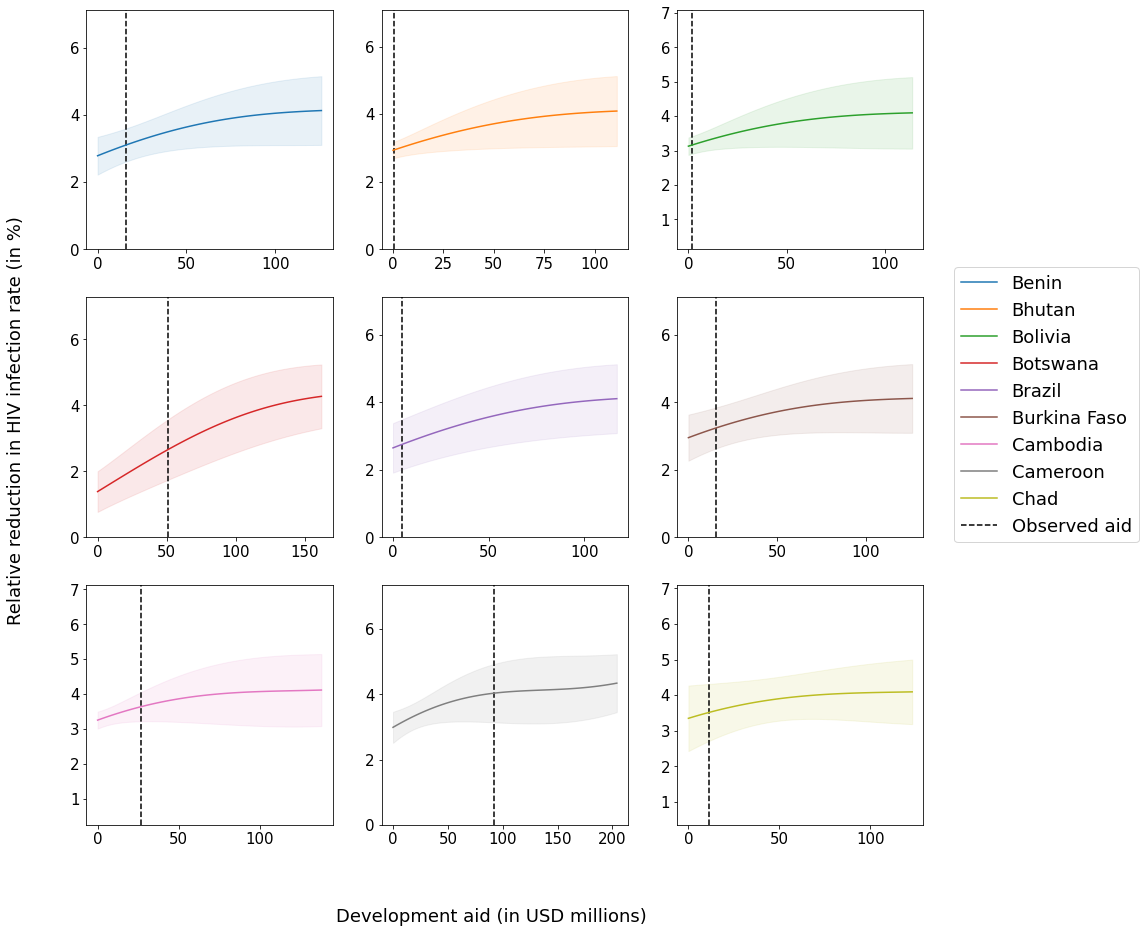

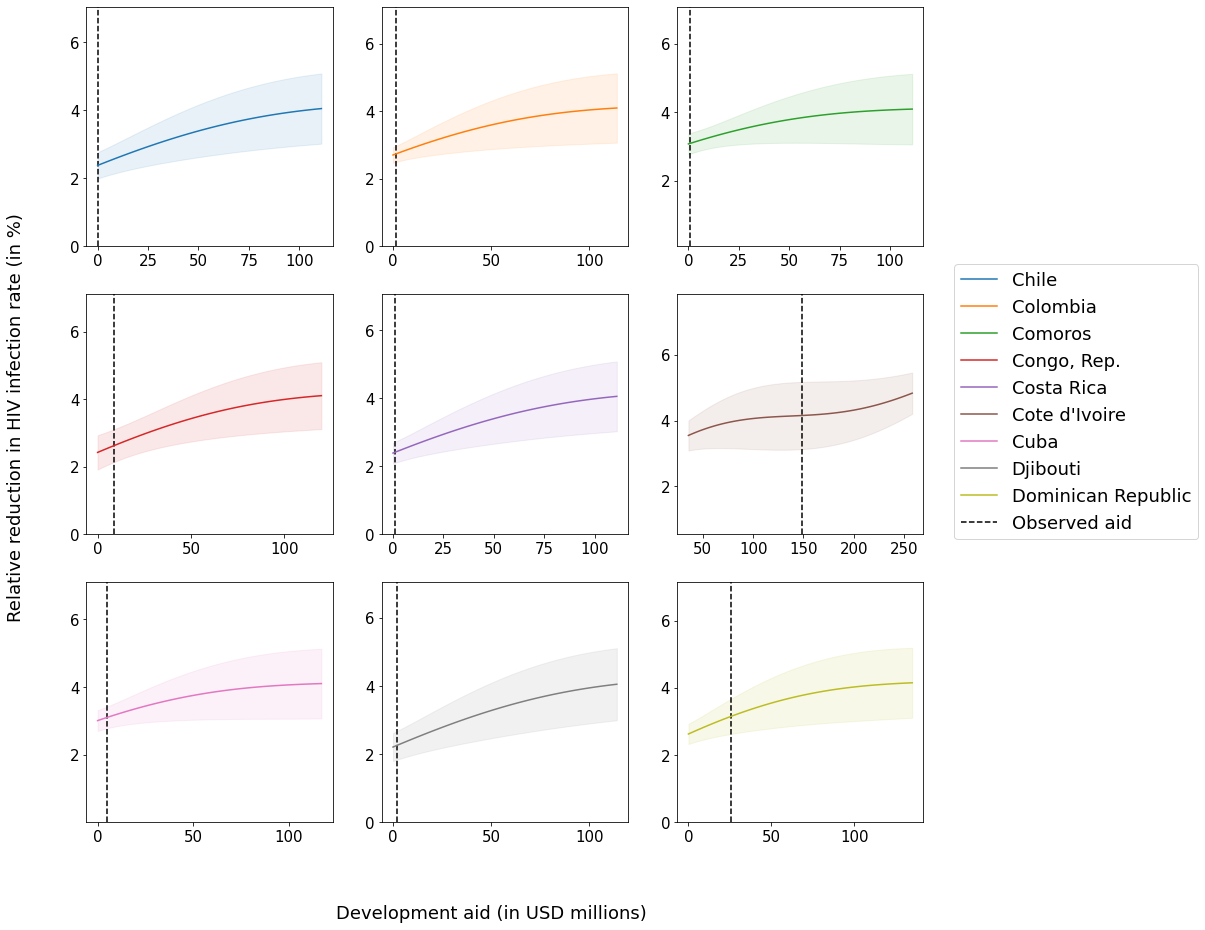

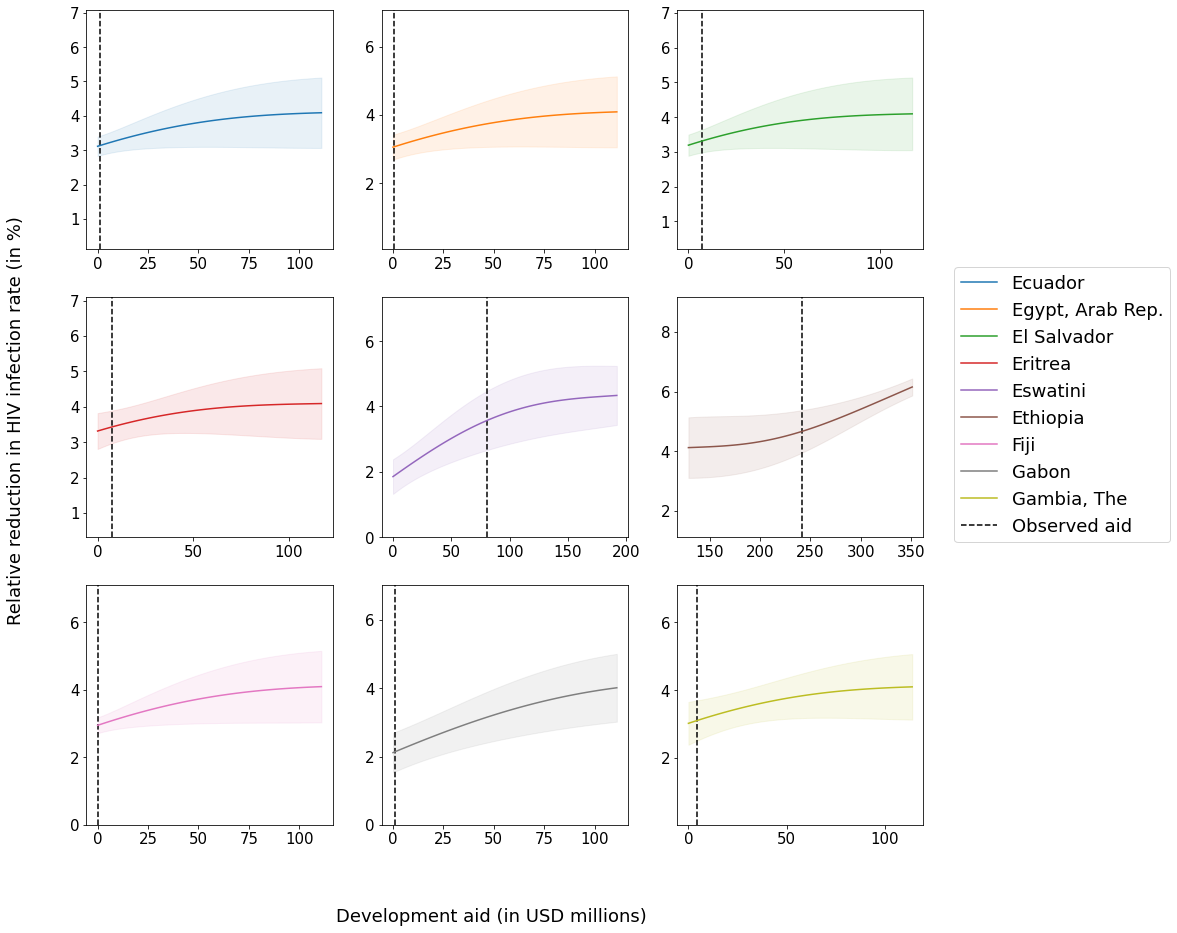

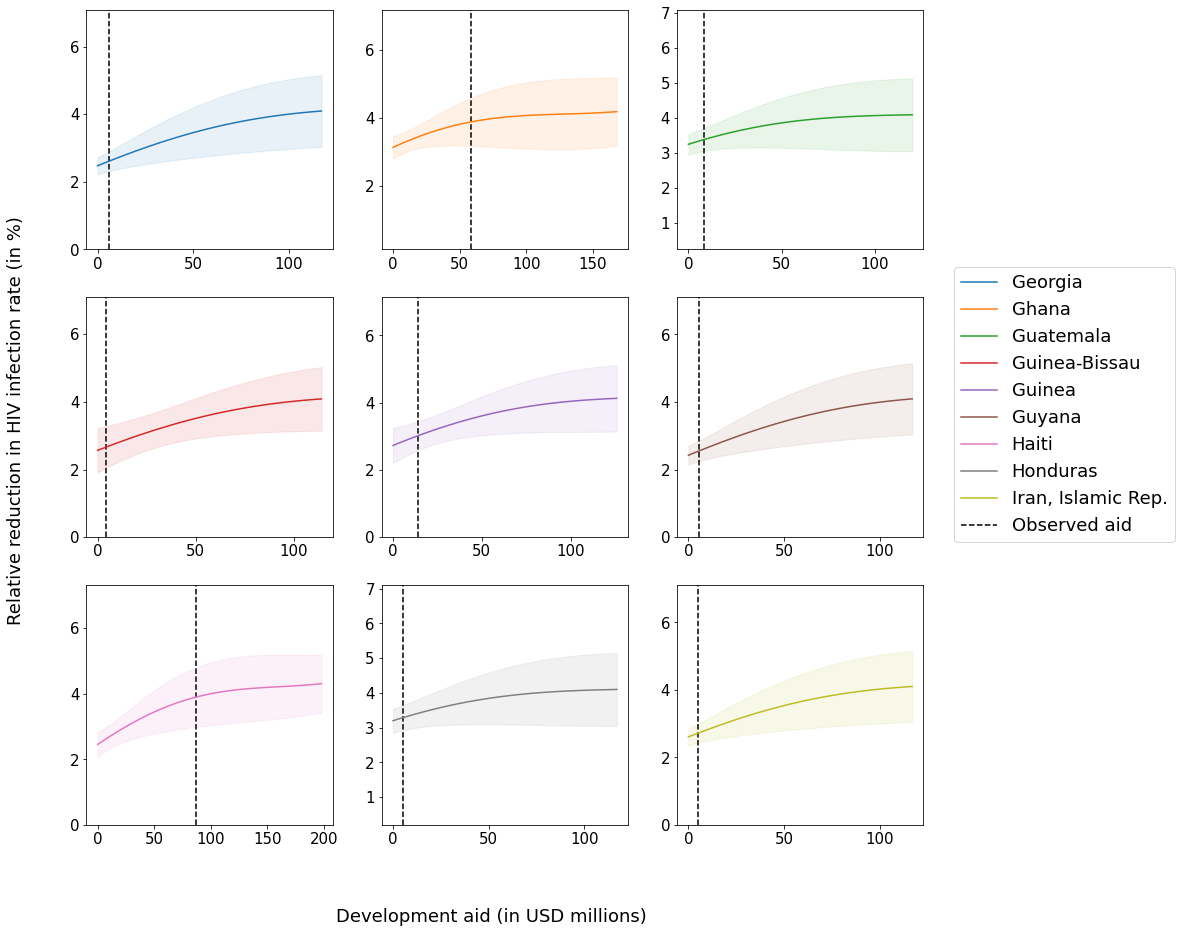

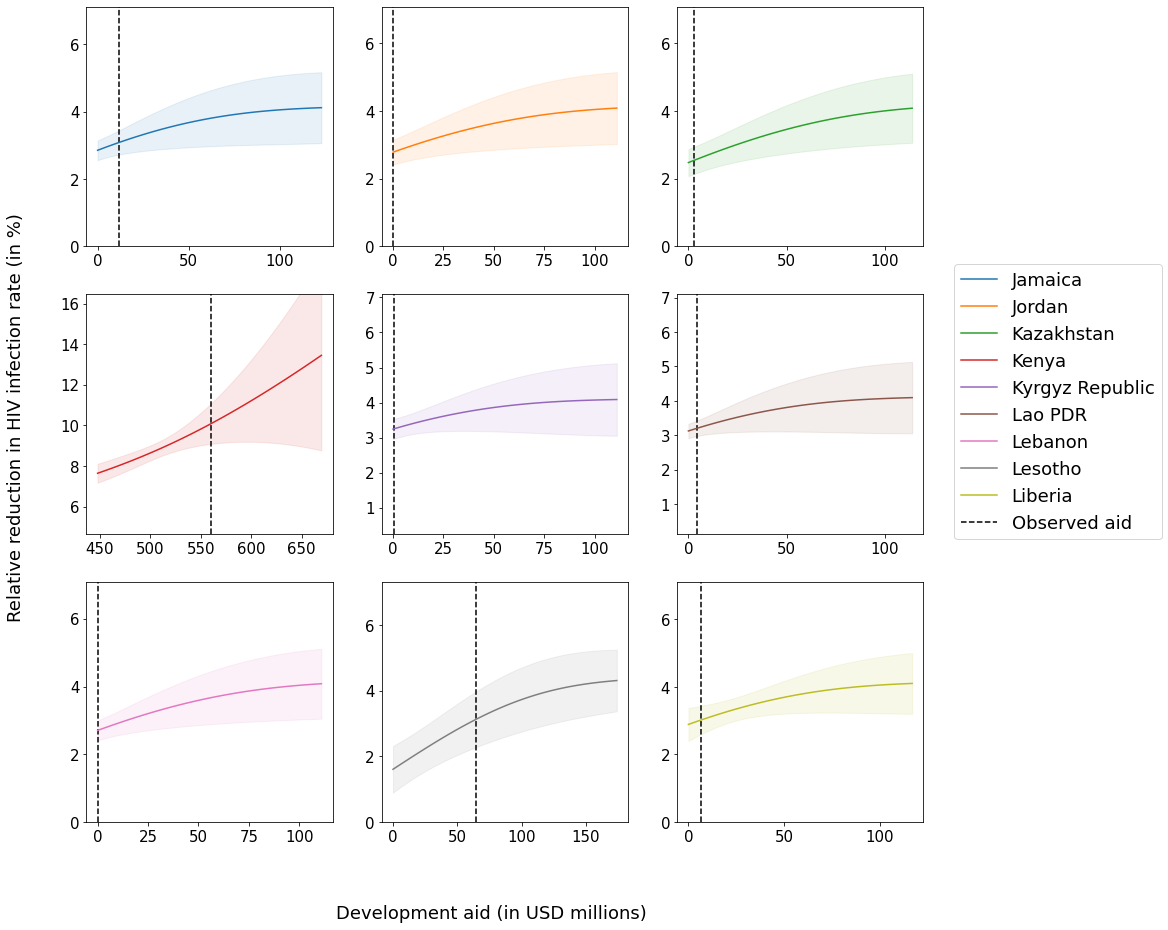

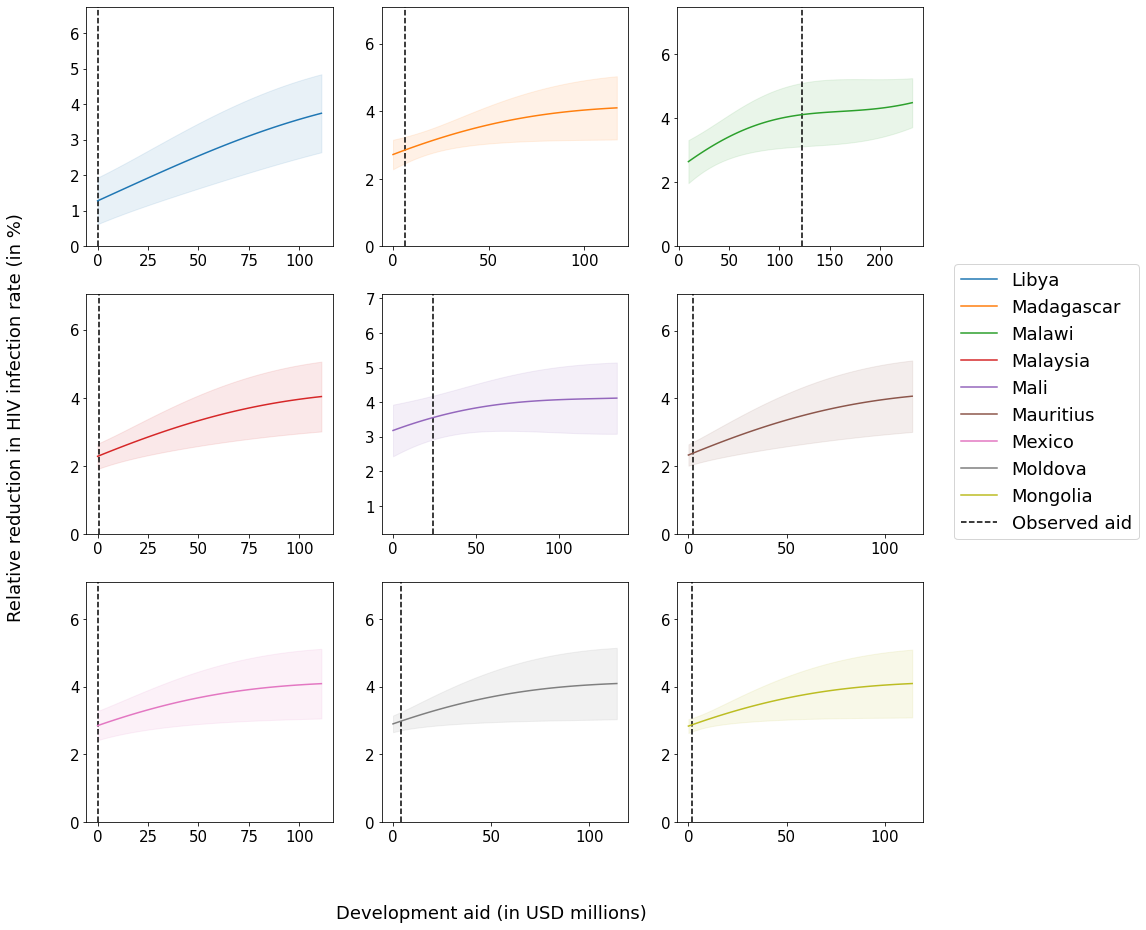

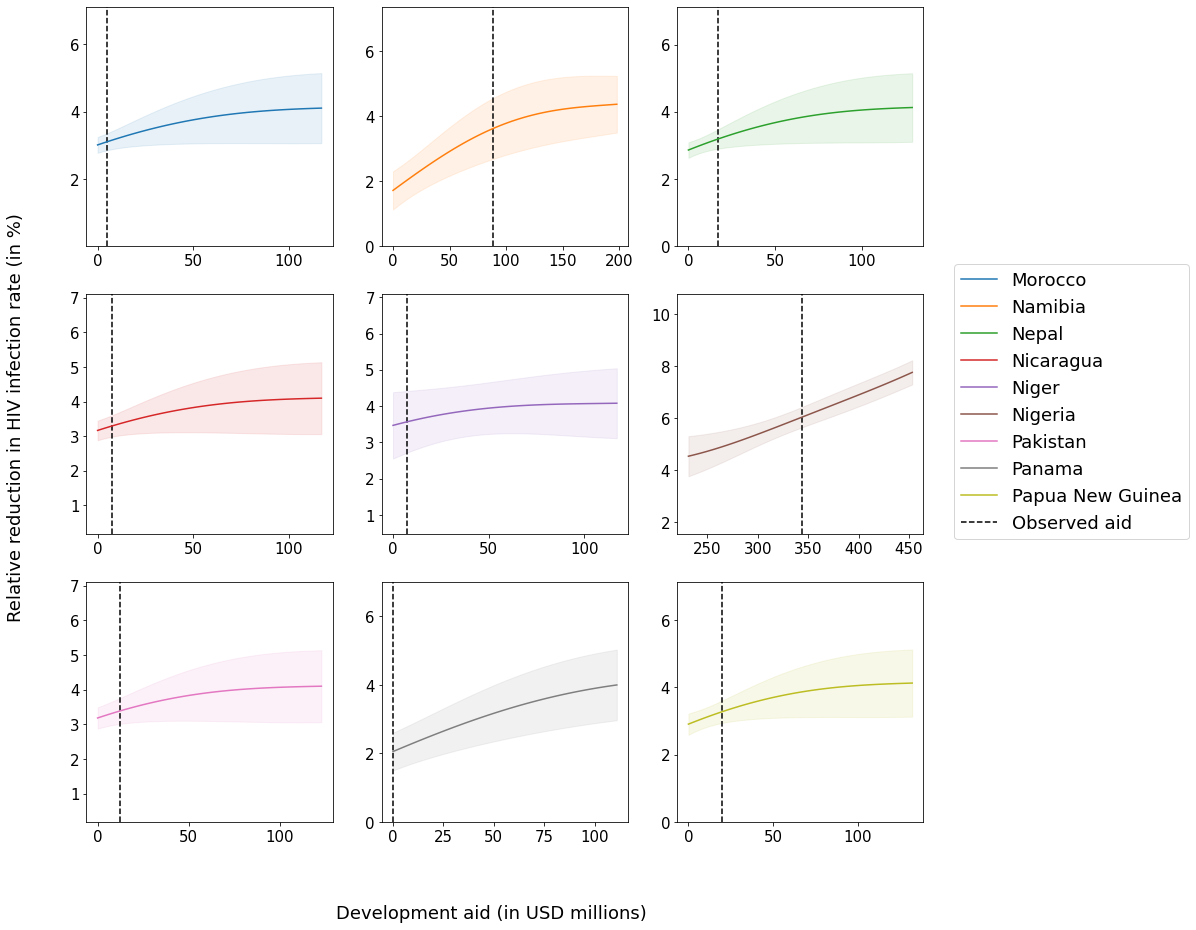

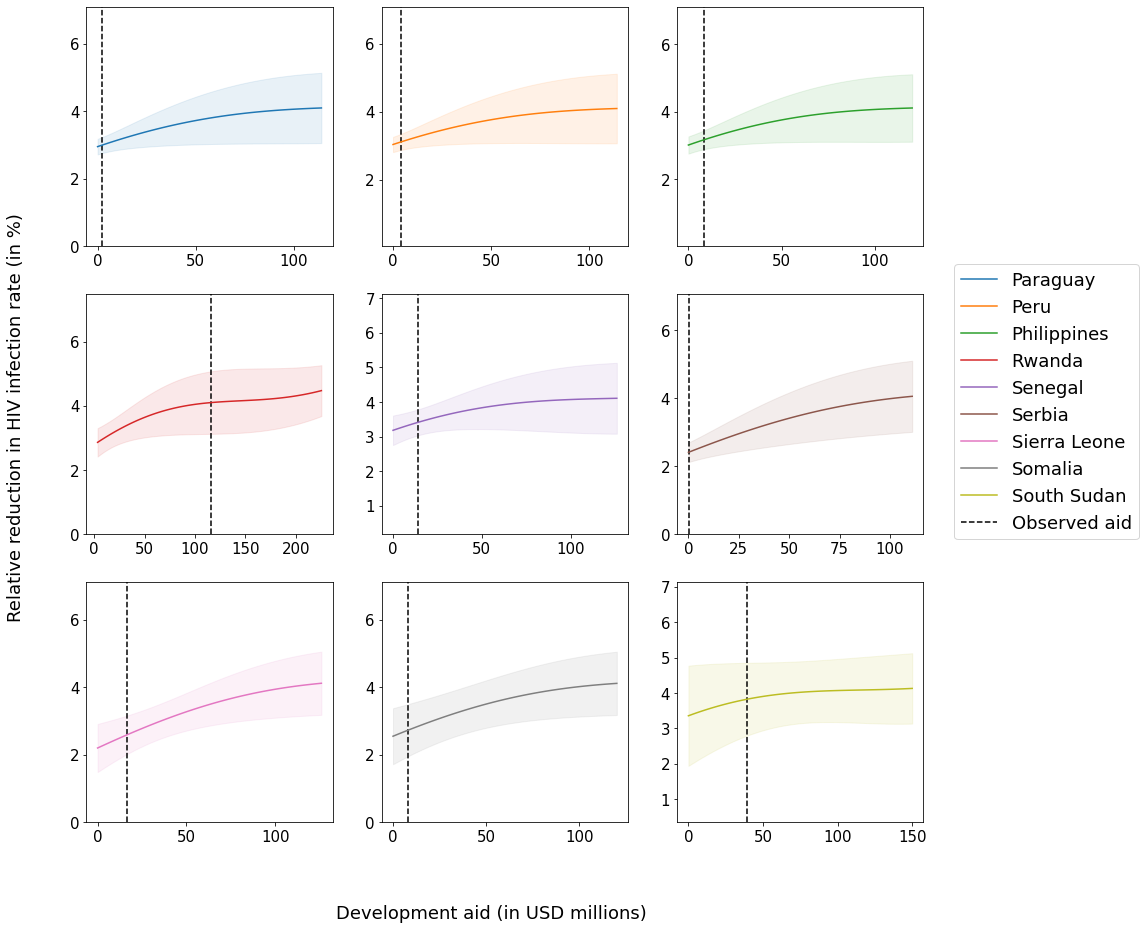

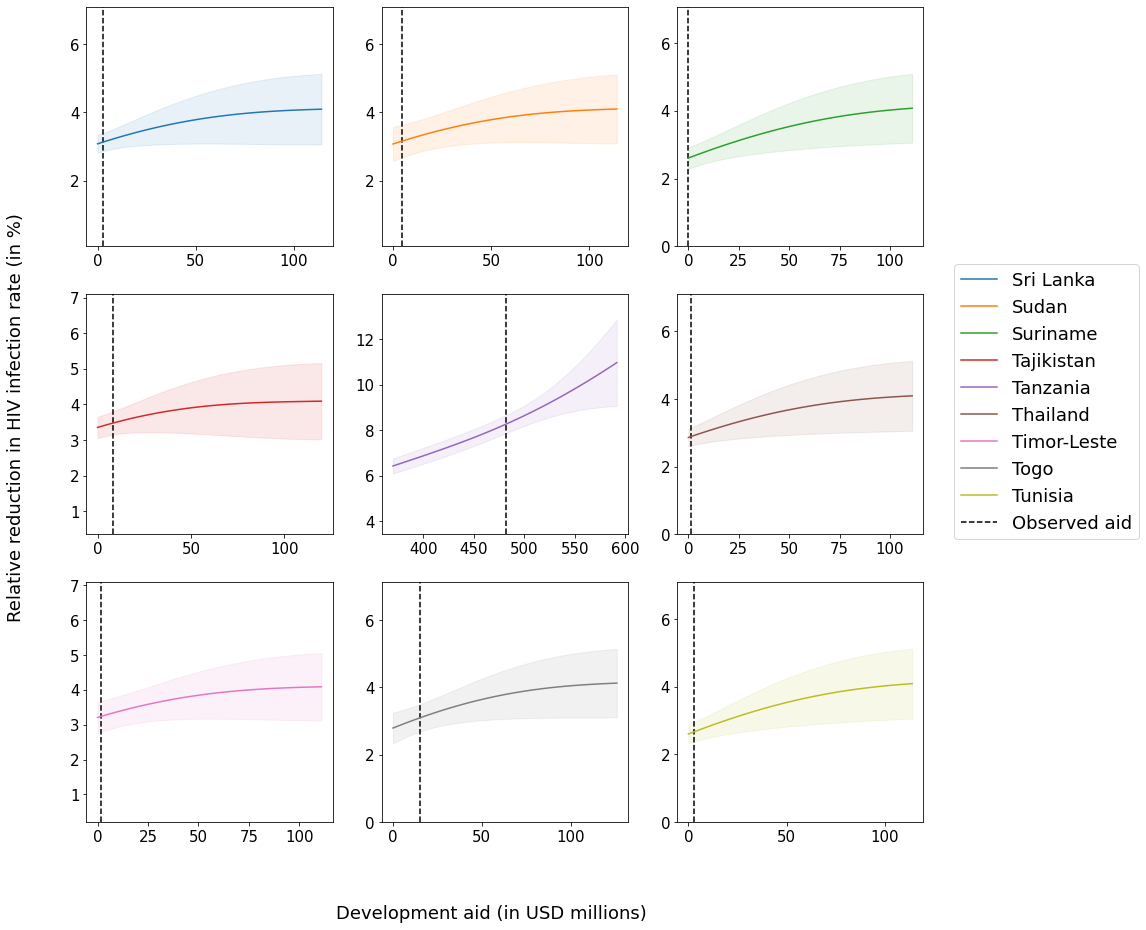

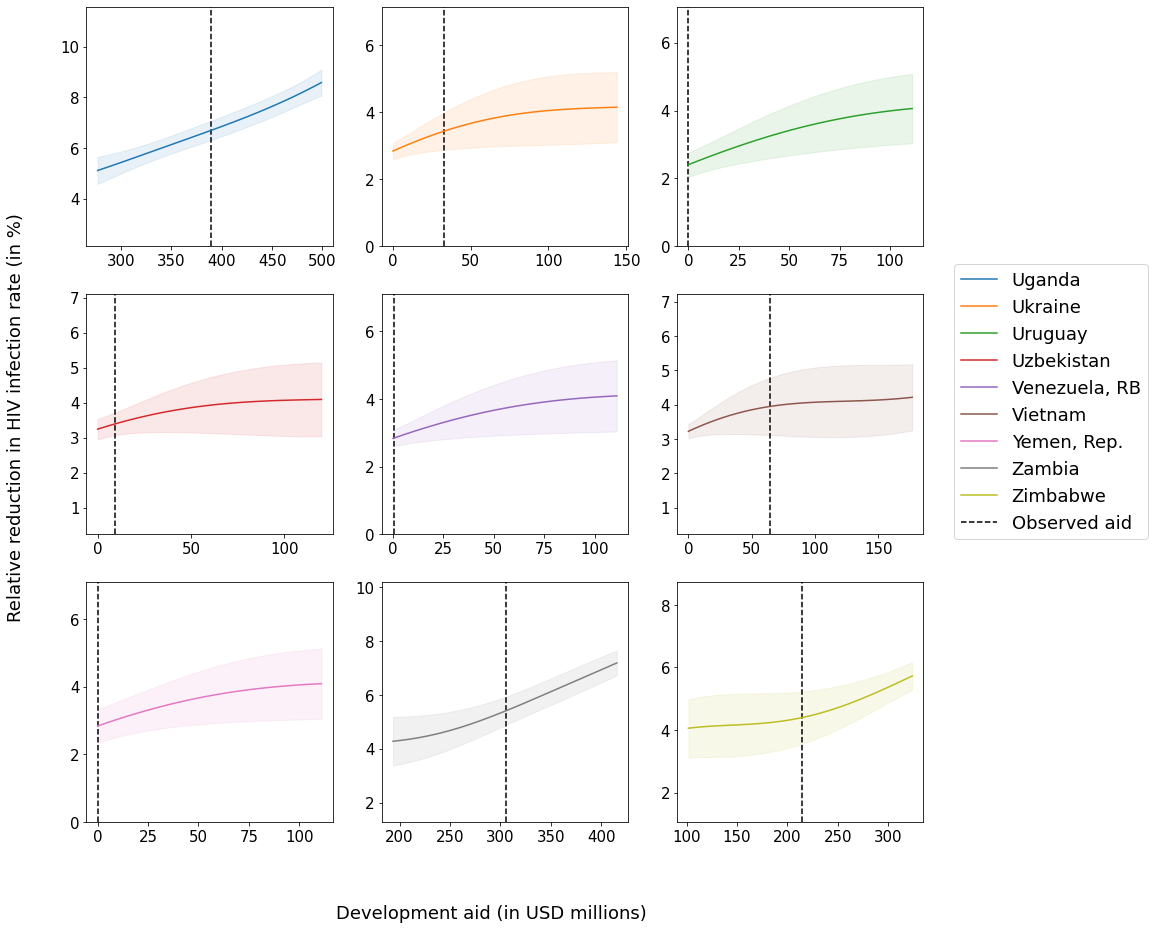

In [22]:
# Plot treatment response curves for all countries

countries = ['South Africa', 'Mozambique', 'Burundi', 'Congo, Dem. Rep.', 'India', 'Indonesia']
remaining_countries = df[~df['country'].isin(countries)]['country'].unique()

a_sig = np.std(df['hiv_aid'])
GPS_mods = np.load('plot_data/tr_var.npz')
b_coef = GPS_mods['b_coef']
sig_hat = GPS_mods['sig_hat']
a_coef = GPS_mods['a_coef']
df_baes = GPS_mods['df_bae']

for ctry_ind in range(11):

    fig, axs = plt.subplots(3, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.rc('axes', titlesize=18)
    plt.rc('axes', labelsize=18)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('legend', fontsize=18) 
    color_cycle = plt.rcParams['axes.prop_cycle']()
    countries = remaining_countries[ctry_ind*9:(ctry_ind+1)*9]

    # Country 1
    country = countries[0]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j:(j+1)], sig_hat[:,j:(j+1)], a_coef[:,j:(j+1)])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i]
    axs[0,0].plot(a, y, label=country, **next(color_cycle))
    axs[0,0].fill_between(a, (y-ci), (y+ci), color='tab:blue', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[0,0].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                    colors='black', linestyle='dashed')
    axs[0,0].set_ylim([y_min, y_max])

    # Country 2
    country = countries[1]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[0,1].plot(a, y, label=country, **next(color_cycle))
    axs[0,1].fill_between(a, (y-ci), (y+ci), color='tab:orange', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[0,1].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                    colors='black', linestyle='dashed')
    axs[0,1].set_ylim([y_min, y_max])

    # Country 3
    country = countries[2]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs-a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[0,2].plot(a, y, label=country, **next(color_cycle))
    axs[0,2].fill_between(a, (y-ci), (y+ci), color='tab:green', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[0,2].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                    colors='black', linestyle='dashed')
    axs[0,2].set_ylim([y_min, y_max])

    # Country 4
    country = countries[3]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[1,0].plot(a, y, label=country, **next(color_cycle))
    axs[1,0].fill_between(a, (y-ci), (y+ci), color='tab:red', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[1,0].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                    colors='black', linestyle='dashed')
    axs[1,0].set_ylim([y_min, y_max])

    # Country 5
    country = countries[4]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[1,1].plot(a, y, label=country, **next(color_cycle))
    axs[1,1].fill_between(a, (y-ci), (y+ci), color='tab:purple', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[1,1].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                    colors='black', linestyle='dashed')
    axs[1,1].set_ylim([y_min, y_max])

    # Country 6
    country = countries[5]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[1,2].plot(a, y, label=country, **next(color_cycle))
    axs[1,2].fill_between(a, (y-ci), (y+ci), color='tab:brown', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[1,2].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max, 
                    colors='black', linestyle='dashed')
    axs[1,2].set_ylim([y_min, y_max])

    # Country 7
    country = countries[6]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[2,0].plot(a, y, label=country, **next(color_cycle))
    axs[2,0].fill_between(a, (y-ci), (y+ci), color='tab:pink', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[2,0].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max, 
                    colors='black', linestyle='dashed')
    axs[2,0].set_ylim([y_min, y_max])

    # Country 8
    country = countries[7]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[2,1].plot(a, y, label=country, **next(color_cycle))
    axs[2,1].fill_between(a, (y-ci), (y+ci), color='tab:grey', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[2,1].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max, 
                    colors='black', linestyle='dashed')
    axs[2,1].set_ylim([y_min, y_max])

    # Country 9
    country = countries[8]
    a_obs = df[df['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    if a_obs - a_sig > 0:
        a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
    else:
        a = np.arange(0, a_obs+a_sig, 3)
    tr_curves = np.empty((len(a),10))
    y = np.empty(len(a))
    ci = np.empty(len(a))
    for i in range(len(a)):
        for j in range(10):
            country_ind = np.where(df['country'] == country)[0]
            tr_curves[i,j] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, j]), axis=1) , b_coef[:,j], sig_hat[:,j], a_coef[:,j])*100
        y[i] = tr_curves[i,0]
        ci[i] = np.std(tr_curves, axis=1)[i] 
    axs[2,2].plot(a, y, label=country, **next(color_cycle))
    axs[2,2].fill_between(a, (y-ci), (y+ci), color='tab:olive', alpha=.1)
    y_min = y.min() - 3
    if y_min < 0:
        y_min = 0
    y_max = y.max() + 3
    axs[2,2].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max, 
                    colors='black', linestyle='dashed', label='Observed aid')
    axs[2,2].set_ylim([y_min, y_max])

    fig.text(0.5, 0.04, 'Development aid (in USD millions)', ha='center', va='center', size=18)
    fig.text(0.06, 0.5, "Relative reduction in HIV infection rate (in %)", ha='center', va='center', rotation='vertical', size=18)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, bbox_to_anchor=(0.92, 0.65), loc='upper left')
    
    file_name = "aid_response_curves_" + str(ctry_ind) + ".pdf"
#     plt.savefig(file_name, bbox_inches='tight')


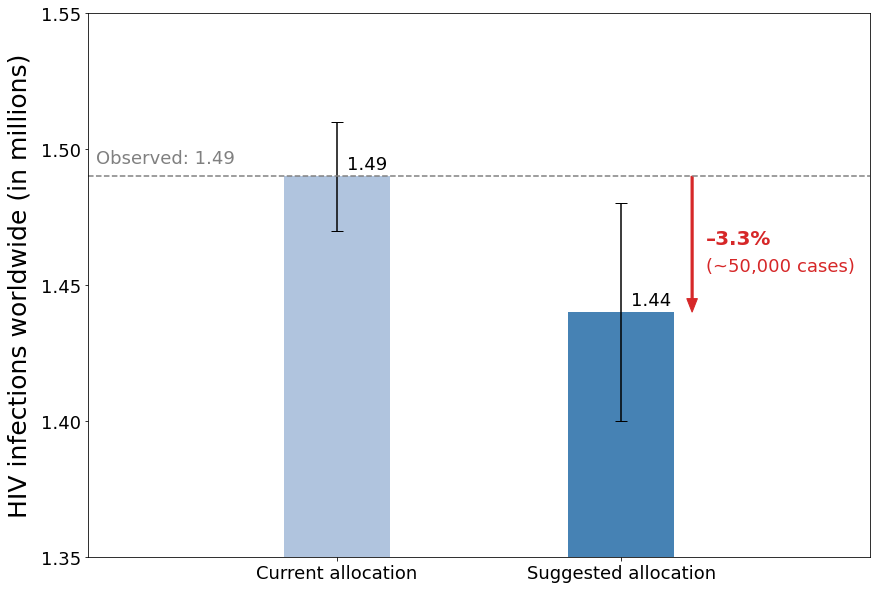

In [24]:
# Bar plot - optimal allocation

Y_data = np.sum(df['hiv_cases'])
opt_alloc = np.load('plot_data/opt_alloc.npz')
Y_opt = opt_alloc['Y_opt']
Y_obs = opt_alloc['Y_obs']
Y_data, Y_obs, Y_opt = np.round(Y_data/1000,2), np.round(Y_obs/1000000,2), np.round(Y_opt/1000000,2)
boot_sample = np.load('plot_data/CI.npz')
Y_opt_sample = boot_sample['Y_opt']
Y_obs_sample = boot_sample['Y_obs']
Y_opt_sample, Y_obs_sample = Y_opt_sample/1000000, Y_obs_sample/1000000
Y_opt_sd, Y_obs_sd = np.round(np.std(Y_opt_sample),2), np.round(np.std(Y_obs_sample),2)

# Real-world

fig, ax = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(14)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

results = [Y_obs, Y_opt]
sd = [Y_obs_sd, Y_opt_sd]
allocation = [0.35,0.75]

pps = ax.bar(allocation, height=results, yerr=sd, align='center', ecolor='black', capsize=6, 
             width=0.15, color=['lightsteelblue', 'steelblue'])
for i,p in enumerate(pps):
    height = p.get_height()
    ax.annotate('{}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(30, 3), 
        textcoords="offset points",
        ha='center', va='bottom', size=18)
    
ax.set_ylabel('HIV infections worldwide (in millions)', labelpad=10, size=25)
ax.set_ylim([1.35, 1.55])
ax.set_yticks([1.35, 1.4, 1.45, 1.5, 1.55])
ax.set_xticks([0.35,0.75])
ax.set_xticklabels(['Current allocation', 'Suggested allocation'])
ax.set_xlim([0, 1.1])
ax.hlines(y=Y_data, xmin=0, xmax=1.1, colors='grey', linestyle='dashed')
ax.annotate('Observed: 1.49',
            xy=(0.01, 1.495),
            xytext=(0.01, 1.495), 
            size=18, color='grey')
ax.arrow(0.85, 1.49, 0, -0.05,
        color='tab:red', linestyle='-',
        length_includes_head=True,
        width=0.003, head_width=0.015,
        head_length=0.005)
ax.annotate('–3.3%',
            xy=(0.87, 1.465),
            xytext=(0.87, 1.465), 
            size=20, color='tab:red',
            rotation=-0, weight='bold')
ax.annotate('(~50,000 cases)',
            xy=(0.87, 1.455),
            xytext=(0.87, 1.455), 
            size=18, color='tab:red',
            rotation=-0)

ax.set_title("")

# fig.savefig("res_allocation.pdf", bbox_inches='tight')


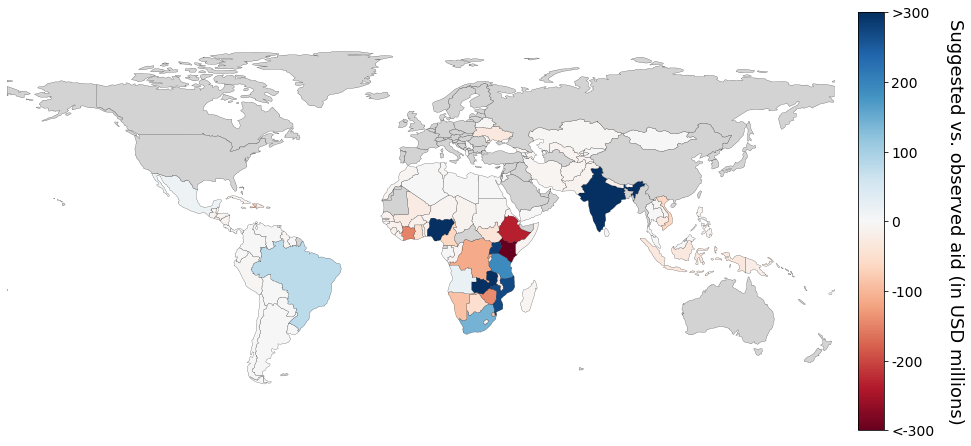

In [26]:
# Visualize optimal allocation

A_opt = np.load('plot_data/opt_alloc.npz')['A_opt']

df = pd.read_csv('data/HIV_data.csv') 
year = 2016
df = df[df['year'] == year]
hiv_rate_previous = df['hiv_rate'].values

df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
population = df['population'].values

df['hiv_aid_opt'] = A_opt
df['aid_difference'] = df['hiv_aid_opt'] - df['hiv_aid']
df.head(5)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
map_data = world.merge(df, how="left", left_on=['iso_a3'], right_on=['id'])
map_data.head(5)

plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

f,ax = plt.subplots(figsize=(16,10),facecolor = 'white')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=.1)

plot2 = map_data.plot(column='aid_difference',         
              ax=ax,
              cax=cax,
              missing_kwds={'color': 'lightgrey'},
              legend_kwds={'ticks':[-300, -200, -100, 0, 100, 200, 300]},              
              legend=True,
              edgecolor='black',
              linewidth=0.2,
              vmin=-300,
              vmax=300,
              cmap='RdBu')

cax.set_yticklabels(['<-300', '-200', '-100', '0', '100', '200', '>300'])
cax.set_ylabel('Suggested vs. observed aid (in USD millions)', rotation=270, labelpad=30)

ax.set_xlim([-180, 180])
ax.set_ylim([-75, 100])
ax.set_axis_off()

fig2 = plot2.get_figure()
# fig2.savefig("optimal_vs_current_allocation.pdf", bbox_inches='tight')


In [28]:
# Overview of covariates

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
df = df.loc[:, ['hiv_reduction', 'hiv_aid','gdp_per_cap_PPP','gdp_growth','inflation','unemployment',
                'population', 'fertility','maternal_mort','infant_mort', 'fdi', 'electricity',
                'life_exp','school_enr', 'tuberculosis', 'undernourishment']]
df.describe()

,hiv_reduction,hiv_aid,gdp_per_cap_PPP,gdp_growth,inflation,unemployment,population,fertility,maternal_mort,infant_mort,fdi,electricity,life_exp,school_enr,tuberculosis,undernourishment
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.032550,50.120621,8.872733,3.812069,7.750452,7.833448,41.662004,3.254295,241.209524,30.946667,3290.619320,73.828879,68.496161,1.036813,162.292381,13.906286
std,0.078541,112.857807,6.789367,3.527058,18.721624,6.227674,135.750569,1.332473,259.076084,20.364246,8750.618053,29.832030,6.904248,0.127265,158.959300,11.651525
min,-0.500000,0.002983,0.773573,-5.071796,-1.537100,0.140000,0.375775,1.259000,2.000000,2.700000,-7397.295409,4.200000,52.947000,0.684745,5.200000,2.500000
25%,0.000000,1.599702,3.153299,2.113129,2.796373,3.600000,5.110701,2.219000,43.000000,13.200000,200.902719,48.472744,63.290000,0.983680,43.000000,5.900000
50%,0.029412,6.348344,7.257812,3.815702,4.378399,5.650000,11.980960,2.849000,144.000000,26.600000,888.835228,90.295815,69.509000,1.033807,99.000000,9.100000
75%,0.080402,25.465566,12.770964,5.069786,7.636113,11.180000,31.104655,4.359000,375.000000,43.500000,2686.509353,99.635490,74.292000,1.087478,233.000000,20.000000
max,0.173077,559.896750,30.446850,26.680903,187.851630,27.040001,1338.676779,7.001000,1150.000000,87.300000,68885.491315,100.000000,79.914000,1.454889,738.000000,58.700000


In [30]:
# Covariate shift analysis across treatment groups
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
hiv_aid = df['hiv_aid']
quantiles = np.quantile(hiv_aid, [1/3, 2/3])

# Small development aid
df1 = pd.read_csv('data/HIV_data.csv')
year = 2017
df1 = df1[(df1['year'] == year) & (df1['hiv_aid'] < quantiles[0])]
df1 = df1.loc[:, ['gdp_per_cap_PPP','gdp_growth','inflation','unemployment',
                  'population', 'fertility','maternal_mort','infant_mort', 'fdi', 'electricity',
                  'life_exp','school_enr', 'tuberculosis', 'undernourishment']]
df1.describe()


,gdp_per_cap_PPP,gdp_growth,inflation,unemployment,population,fertility,maternal_mort,infant_mort,fdi,electricity,life_exp,school_enr,tuberculosis,undernourishment
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,14.130875,3.685304,5.344238,8.764171,18.984560,2.461457,80.771429,17.911429,3401.921345,94.545098,73.488733,1.024729,92.580000,9.134857
std,6.601215,4.765847,5.843467,5.851679,28.395408,0.758990,72.433777,12.542112,6264.705224,9.581826,4.249574,0.090311,133.423042,8.429576
min,3.032262,-5.071796,0.417336,0.830000,0.375775,1.440000,12.000000,5.100000,-269.850000,60.200001,63.912000,0.695962,6.700000,2.500000
25%,10.997692,1.597473,2.417322,4.444000,2.469135,1.904000,31.000000,8.850000,130.502708,93.944504,71.164500,0.995363,25.000000,4.050000
50%,12.770964,3.802227,3.666997,6.960000,6.819373,2.294000,46.000000,13.700000,1230.243451,99.300003,74.365000,1.029341,43.000000,6.700000
75%,17.853320,4.775008,6.172052,11.036500,24.639406,2.818500,122.500000,21.000000,2909.761478,99.895000,76.616000,1.070445,82.000000,10.100000
max,30.446850,26.680903,29.506608,26.059999,124.777326,4.275000,273.000000,51.600000,33170.534975,100.000000,79.914000,1.197651,529.000000,46.600000


In [32]:
# Medium development aid
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
hiv_aid = df['hiv_aid']
quantiles = np.quantile(hiv_aid, [1/3, 2/3])

df2 = pd.read_csv('data/HIV_data.csv')
year = 2017
df2 = df2[(df2['year'] == year) & (df2['hiv_aid'] >= quantiles[0]) & (df2['hiv_aid'] <= quantiles[1])]
df2 = df2.loc[:, ['gdp_per_cap_PPP','gdp_growth','inflation','unemployment',
                  'population', 'fertility','maternal_mort','infant_mort', 'fdi', 'electricity',
                  'life_exp','school_enr', 'tuberculosis', 'undernourishment']]
df2.describe()


,gdp_per_cap_PPP,gdp_growth,inflation,unemployment,population,fertility,maternal_mort,infant_mort,fdi,electricity,life_exp,school_enr,tuberculosis,undernourishment
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,7.336664,3.701440,5.201462,7.232229,29.392074,3.379657,263.714286,30.885714,3573.729225,74.316892,68.742293,0.994952,133.268571,14.643429
std,5.831189,2.732589,5.676901,5.480885,49.546135,1.453985,285.312787,20.863832,11578.495203,29.976437,6.521224,0.120400,122.454428,13.126187
min,1.079112,-4.382531,-1.537100,0.542000,0.775218,1.259000,2.000000,2.700000,15.691198,10.900000,53.712000,0.684745,5.200000,2.500000
25%,2.065524,2.486996,2.303775,3.495000,6.386484,2.247000,44.500000,13.450000,333.027181,49.613731,64.042000,0.941257,44.000000,5.300000
50%,6.004014,4.100000,4.378399,5.530000,11.433438,2.750000,121.000000,25.900000,888.835228,93.000000,70.647000,1.021758,90.000000,10.900000
75%,11.442904,4.842759,6.764011,11.405000,28.507405,4.475500,438.000000,45.550000,2208.314147,99.550003,74.098634,1.059988,172.000000,21.590000
max,24.862966,10.300000,32.351626,20.559000,207.906210,7.001000,1140.000000,79.100000,68885.491315,100.000000,78.662000,1.243510,554.000000,58.700000


In [34]:
# High development aid
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
hiv_aid = df['hiv_aid']
quantiles = np.quantile(hiv_aid, [1/3, 2/3])

df3 = pd.read_csv('data/HIV_data.csv')
year = 2017
df3 = df3[(df3['year'] == year) & (df3['hiv_aid'] > quantiles[1])]
df3 = df3.loc[:, ['gdp_per_cap_PPP','gdp_growth','inflation','unemployment',
                  'population', 'fertility','maternal_mort','infant_mort', 'fdi', 'electricity',
                  'life_exp','school_enr', 'tuberculosis', 'undernourishment']]
df3.describe()


,gdp_per_cap_PPP,gdp_growth,inflation,unemployment,population,fertility,maternal_mort,infant_mort,fdi,electricity,life_exp,school_enr,tuberculosis,undernourishment
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,5.150661,4.049462,12.705656,7.503943,76.609376,3.921771,379.142857,44.042857,2896.207389,52.624646,63.257456,1.090758,261.028571,17.940571
std,4.274085,2.790107,31.109757,7.278418,226.198882,1.272346,268.431516,18.011782,7788.503176,28.756371,5.590370,0.148122,169.080643,11.452323
min,0.773573,-3.141950,0.642674,0.140000,1.124808,1.374000,19.000000,7.600000,-7397.295409,4.200000,52.947000,0.801708,46.000000,2.500000
25%,2.059520,2.491401,3.318227,2.888500,10.946570,2.948000,181.500000,32.500000,198.583909,33.110577,59.667500,0.988244,157.000000,7.200000
50%,3.665118,3.976290,5.640932,4.563000,19.193236,4.088000,342.000000,39.500000,802.704141,44.299999,63.043000,1.072162,221.000000,15.400000
75%,6.669183,5.937522,11.112562,8.945000,47.526141,4.914000,502.000000,57.100000,2366.023444,76.250000,67.125000,1.154720,325.500000,25.550000
max,16.735364,9.564190,187.851630,27.040001,1338.676779,6.017000,1150.000000,87.300000,39966.091359,100.000000,75.241000,1.454889,738.000000,48.000000


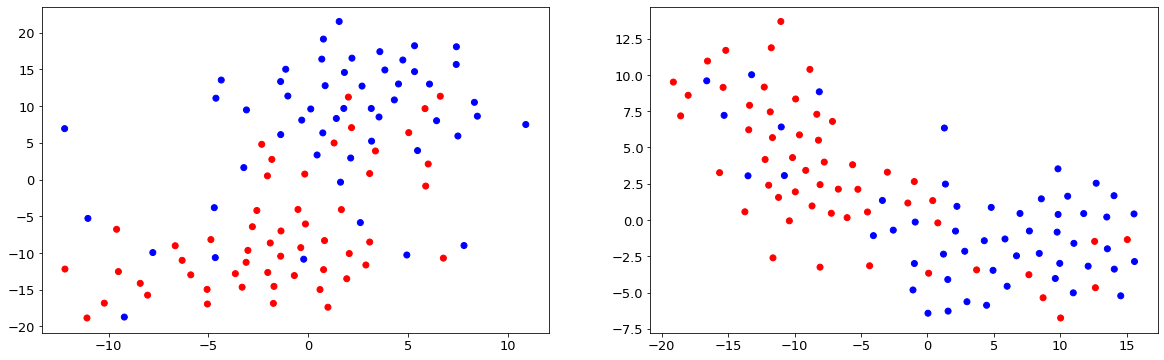

In [37]:
# Visualize representation

# TSNE on original data

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]

# Prepare real world data
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
Y = df.iloc[:, -1].to_numpy()

n = X.shape[0]
p = X.shape[1]

data2 = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled2 = scaler.fit_transform(data2[:,2:])
data_test = np.concatenate([data2[:,0:2], data_scaled2], axis=1)
data_tsne_original = data_test[:,2:]
    
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results_original = tsne.fit_transform(data_tsne_original)

# TSNE on balanced data

# Real-world - train
df = pd.read_csv('data/HIV_data.csv') 
year = 2016
df = df[df['year'] == year]
hiv_rate_previous = df['hiv_rate'].values

# Prepare real world data
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
Y = df.iloc[:, -1].to_numpy()

n = X.shape[0]
p = X.shape[1]

data = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[:,2:])
data_train = np.concatenate([data[:,0:2], data_scaled], axis=1)

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
population = df['population'].values

# Prepare real world data
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
Y = df.iloc[:, -1].to_numpy()

n = X.shape[0]
p = X.shape[1]

data2 = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled2 = scaler.fit_transform(data2[:,2:])
data_test = np.concatenate([data2[:,0:2], data_scaled2], axis=1)

# Hyperpar list
hyper_opt_list = open("hyperpars/hyper_opt_list_HIV2017.txt", "r")
hyper_opt_list = hyper_opt_list.read()
hyper_opt = ast.literal_eval(hyper_opt_list)
opt_hyperpars = hyper_opt[-1]

# Set all seeds
np.random.seed(123)
torch.manual_seed(123)

# Estimate model
data_train_bae, mod_BAE = BAE(data_train, opt_hyperpars)    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
X = torch.from_numpy(data_test[:,2:].astype(np.float32))
X = X.to(device)
X_reduced, _, _ = mod_BAE(X)
X_reduced = X_reduced.cpu().detach().numpy()
data_test_bae = np.concatenate([data_test[:,0:2],X_reduced], axis=1)                                     
data_tsne_bae = data_test_bae[:,2:]

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results_bae = tsne.fit_transform(data_tsne_bae)

# # Aid volume group
A = data_test[:,1]
n_groups = 2
sep = np.round(np.quantile(A, q=[0, 0.5, 1]))
l_enc = np.empty((n,n_groups))
for i in range(n):
    for j in range(n_groups):
        if A[i] >= sep[j] and A[i] <= sep[j+1]:
            l_enc[i,j] = 1
        else:
            l_enc[i,j] = 0
A_group = np.empty(n)
for i in range(n):
    A_group[i] = np.where(l_enc[i,:] == 1)[0]
    
# Visualize representation

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(20)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

ax1.scatter(x=tsne_results_original[:,0], y=tsne_results_original[:,1],
           c=A_group, cmap='bwr')

ax1.set(xlabel='', ylabel="")
ax1.set_title("")

ax2.scatter(x=tsne_results_bae[:,0], y=tsne_results_bae[:,1],
           c=A_group, cmap='bwr')

ax2.set(xlabel='', ylabel="")
ax2.set_title("")

plt.show()

#fig.savefig("tsne_covariate_representation.pdf", bbox_inches='tight')

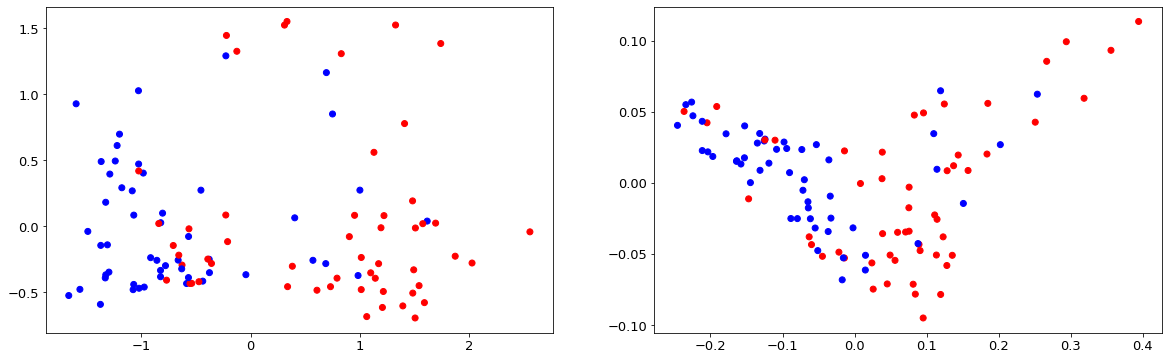

In [39]:
# Visualize representation

# Isomap on original data

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]

# Prepare real world data
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
Y = df.iloc[:, -1].to_numpy()

n = X.shape[0]
p = X.shape[1]

data2 = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled2 = scaler.fit_transform(data2[:,2:])
data_test = np.concatenate([data2[:,0:2], data_scaled2], axis=1)
data_tsne_original = data_test[:,2:]
    
iso = Isomap(n_components=2)
iso_results_original = iso.fit_transform(data_tsne_original)

# Isomap on balanced data

# Real-world - train
df = pd.read_csv('data/HIV_data.csv') 
year = 2016
df = df[df['year'] == year]
hiv_rate_previous = df['hiv_rate'].values

# Prepare real world data
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
Y = df.iloc[:, -1].to_numpy()

n = X.shape[0]
p = X.shape[1]

data = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[:,2:])
data_train = np.concatenate([data[:,0:2], data_scaled], axis=1)

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
population = df['population'].values

# Prepare real world data
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
Y = df.iloc[:, -1].to_numpy()

n = X.shape[0]
p = X.shape[1]

data2 = np.concatenate([Y.reshape(n,1), A.reshape(n,1), X],axis=1)

# Data standardization: min-max scaler
scaler = MinMaxScaler()
data_scaled2 = scaler.fit_transform(data2[:,2:])
data_test = np.concatenate([data2[:,0:2], data_scaled2], axis=1)

# Hyperpar list
hyper_opt_list = open("hyperpars/hyper_opt_list_HIV2017.txt", "r")
hyper_opt_list = hyper_opt_list.read()
hyper_opt = ast.literal_eval(hyper_opt_list)
opt_hyperpars = hyper_opt[-1]

# Set all seeds
np.random.seed(123)
torch.manual_seed(123)

# Estimate model
data_train_bae, mod_BAE = BAE(data_train, opt_hyperpars)    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
X = torch.from_numpy(data_test[:,2:].astype(np.float32))
X = X.to(device)
X_reduced, _, _ = mod_BAE(X)
X_reduced = X_reduced.cpu().detach().numpy()
data_test_bae = np.concatenate([data_test[:,0:2],X_reduced], axis=1)                                     
data_tsne_bae = data_test_bae[:,2:]

iso = Isomap(n_components=2)
iso_results_bae = iso.fit_transform(data_tsne_bae)

# Aid volume group
A = data_test[:,1]
n_groups = 2
sep = np.round(np.quantile(A, q=[0, 0.5, 1]))
l_enc = np.empty((n,n_groups))
for i in range(n):
    for j in range(n_groups):
        if A[i] >= sep[j] and A[i] <= sep[j+1]:
            l_enc[i,j] = 1
        else:
            l_enc[i,j] = 0
A_group = np.empty(n)
for i in range(n):
    A_group[i] = np.where(l_enc[i,:] == 1)[0]
    
# Visualize representation

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(20)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

ax1.scatter(x=iso_results_original[:,0], y=iso_results_original[:,1],
           c=A_group, cmap='bwr')

ax1.set(xlabel='', ylabel="")
ax1.set_title("")

ax2.scatter(x=iso_results_bae[:,0], y=iso_results_bae[:,1],
           c=A_group, cmap='bwr')

ax2.set(xlabel='', ylabel="")
ax2.set_title("")

plt.show()

#fig.savefig("isomap_covariate_representation.pdf", bbox_inches='tight')

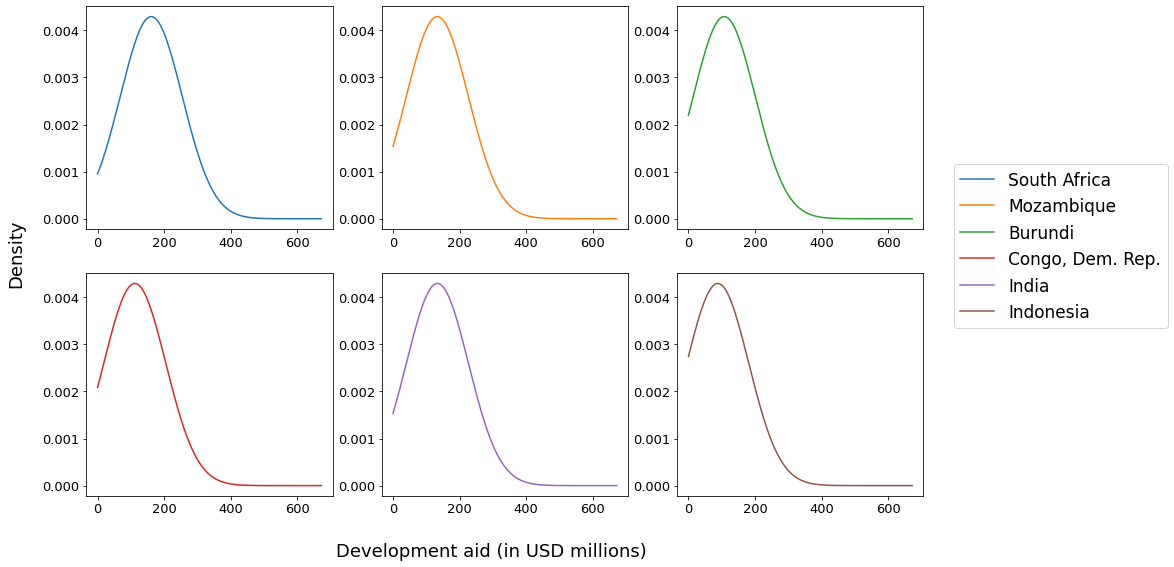

In [4]:
# Positivity analysis

#Load data - train
df = pd.read_csv('data/HIV_data.csv') 
year = 2016
df = df[df['year'] == year]
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
n = X.shape[0]
p = X.shape[1]

#Estimating the propensity score via linear regression
mod_LM = LinearRegression()
A_model = mod_LM.fit(X, A)
coefs = A_model.coef_.reshape(p,1)
intercept = A_model.intercept_
A_pred = A_model.predict(X)
E_sigma = np.sqrt((1/(n-p-1))*np.sum(np.square(A-A_pred)))

#Load data - test
df = pd.read_csv('data/HIV_data.csv') 
year = 2017
df = df[df['year'] == year]
X = df.iloc[:, 5:-2].to_numpy()
A = df.iloc[:, 4].to_numpy()
x_plot = np.arange(0, max(A)+np.std(A), 1)

fig, axs = plt.subplots(2, 3)
fig.set_figheight(9)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 
color_cycle = plt.rcParams['axes.prop_cycle']()

countries = ['South Africa', 'Mozambique', 'Burundi', 'Congo, Dem. Rep.', 'India', 'Indonesia']

# Country 1
country = countries[0]
country_ind = np.where(df['country'] == country)[0]
a_obs = A[country_ind]
a_mean_hat = intercept + np.matmul(X[country_ind, :], coefs)
axs[0,0].plot(x_plot, norm.pdf(x_plot, a_mean_hat, E_sigma).reshape(-1), label=country, **next(color_cycle))

# Country 2
country = countries[1]
country_ind = np.where(df['country'] == country)[0]
a_obs = A[country_ind]
a_mean_hat = intercept + np.matmul(X[country_ind, :], coefs)
axs[0,1].plot(x_plot, norm.pdf(x_plot, a_mean_hat, E_sigma).reshape(-1), label=country, **next(color_cycle))

# Country 3
country = countries[2]
country_ind = np.where(df['country'] == country)[0]
a_obs = A[country_ind]
a_mean_hat = intercept + np.matmul(X[country_ind, :], coefs)
axs[0,2].plot(x_plot, norm.pdf(x_plot, a_mean_hat, E_sigma).reshape(-1), label=country, **next(color_cycle))

# Country 4
country = countries[3]
country_ind = np.where(df['country'] == country)[0]
a_obs = A[country_ind]
a_mean_hat = intercept + np.matmul(X[country_ind, :], coefs)
axs[1,0].plot(x_plot, norm.pdf(x_plot, a_mean_hat, E_sigma).reshape(-1), label=country, **next(color_cycle))

# Country 5
country = countries[4]
country_ind = np.where(df['country'] == country)[0]
a_obs = A[country_ind]
a_mean_hat = intercept + np.matmul(X[country_ind, :], coefs)
axs[1,1].plot(x_plot, norm.pdf(x_plot, a_mean_hat, E_sigma).reshape(-1), label=country, **next(color_cycle))

# Country 6
country = countries[5]
country_ind = np.where(df['country'] == country)[0]
a_obs = A[country_ind]
a_mean_hat = intercept + np.matmul(X[country_ind, :], coefs)
axs[1,2].plot(x_plot, norm.pdf(x_plot, a_mean_hat, E_sigma).reshape(-1), label=country, **next(color_cycle))

fig.text(0.5, 0.04, 'Development aid (in USD millions)', ha='center', va='center', size=18)
fig.text(0.06, 0.5, "Density", ha='center', va='center', rotation='vertical', size=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.92, 0.65), loc='upper left')

# plt.savefig("propensity_scores.pdf", bbox_inches='tight')


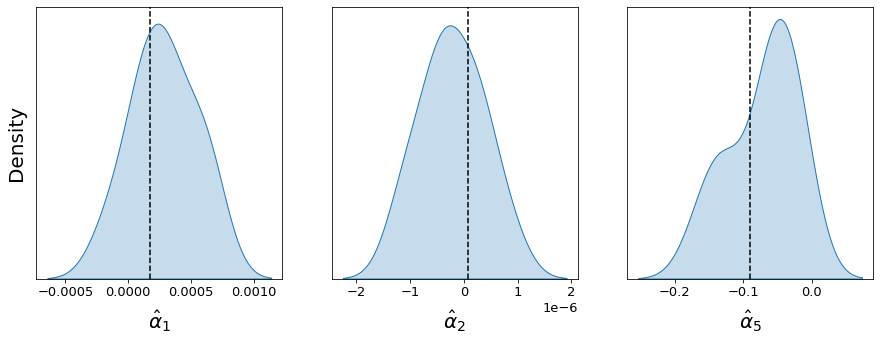

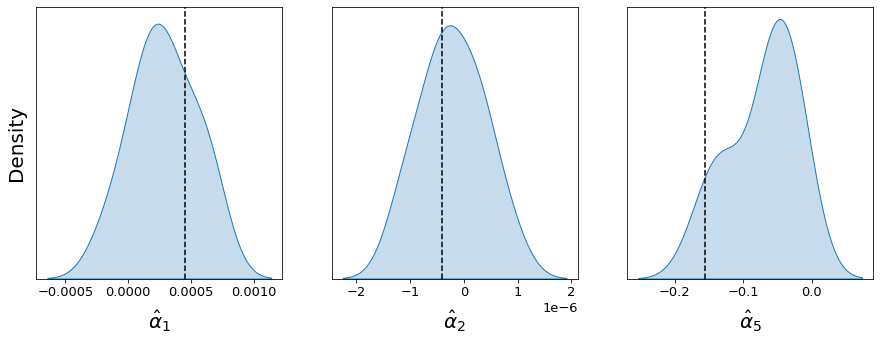

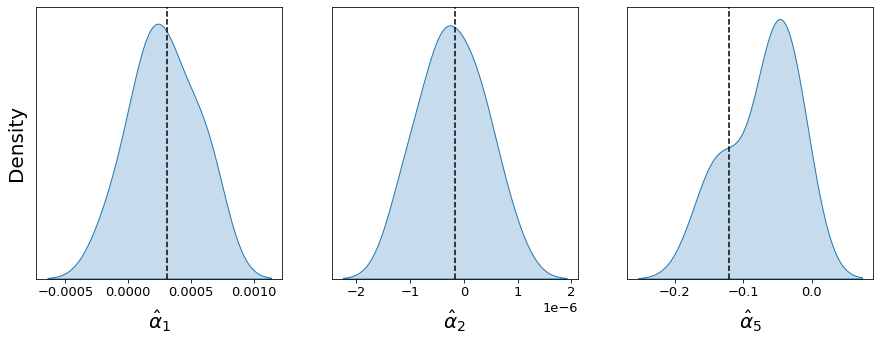

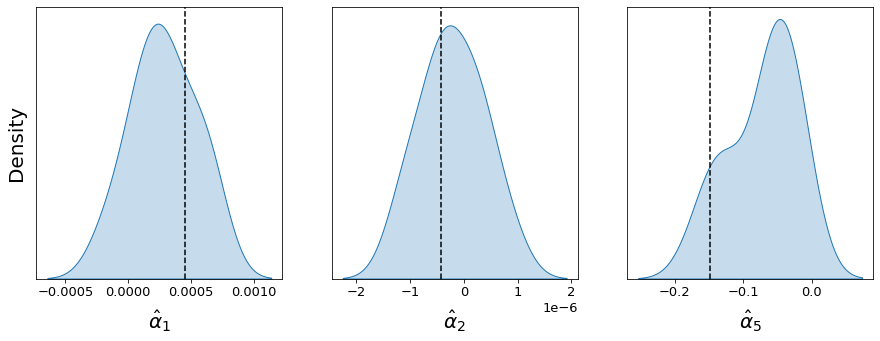

In [6]:
# Ignorability robustness

#Load trained model parameters
GPS_mods = np.load('plot_data/tr_var.npz')
a_coefs = np.load('plot_data/tr_var.npz')['a_coef']
a_coef_ign1 = np.load('plot_data/sens.npz')['past_aid']
a_coef_ign2 = np.load('plot_data/sens.npz')['past_hiv']
a_coef_ign3 = np.load('plot_data/sens.npz')['past_aid_neigh']
a_coef_ign4 = np.load('plot_data/sens.npz')['past_hiv_neigh']
a1, a2, a5 = a_coefs[1,:], a_coefs[2,:], a_coefs[5,:]
a1_ign1, a2_ign1, a5_ign1 = a_coef_ign1[1], a_coef_ign1[2], a_coef_ign1[5]
a1_ign2, a2_ign2, a5_ign2 = a_coef_ign2[1], a_coef_ign2[2], a_coef_ign2[5]
a1_ign3, a2_ign3, a5_ign3 = a_coef_ign3[1], a_coef_ign3[2], a_coef_ign3[5]
a1_ign4, a2_ign4, a5_ign4 = a_coef_ign4[1], a_coef_ign4[2], a_coef_ign4[5]

# Robustness w.r.t. past aid
fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

sns.kdeplot(a1, fill=True, ax=axs[0])
sns.kdeplot(a2, fill=True, ax=axs[1])
sns.kdeplot(a5, fill=True, ax=axs[2])

axs[0].set_xlabel(r'$\hat{\alpha}_1$', labelpad=10, size=20)
axs[1].set_xlabel(r'$\hat{\alpha}_2$', labelpad=10, size=20)
axs[2].set_xlabel(r'$\hat{\alpha}_5$', labelpad=10, size=20)

axs[0].set_ylabel('Density', labelpad=10, size=20)
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_ylim([0, 1400])
axs[1].set_ylim([0, 600000])
axs[2].set_ylim([0, 8])

axs[0].vlines(x=a1_ign1, ymin=0, ymax=1400, colors='black', linestyle='dashed')
axs[1].vlines(x=a2_ign1, ymin=0, ymax=600000, colors='black', linestyle='dashed')
axs[2].vlines(x=a5_ign1, ymin=0, ymax=8, colors='black', linestyle='dashed')

axs[0].tick_params(left=False, labelleft=False)
axs[1].tick_params(left=False, labelleft=False)
axs[2].tick_params(left=False, labelleft=False)

plt.show()

#fig.savefig("robustness_past_aid.pdf", bbox_inches='tight')

# Robustness w.r.t. past HIV
fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

sns.kdeplot(a1, fill=True, ax=axs[0])
sns.kdeplot(a2, fill=True, ax=axs[1])
sns.kdeplot(a5, fill=True, ax=axs[2])

axs[0].set_xlabel(r'$\hat{\alpha}_1$', labelpad=10, size=20)
axs[1].set_xlabel(r'$\hat{\alpha}_2$', labelpad=10, size=20)
axs[2].set_xlabel(r'$\hat{\alpha}_5$', labelpad=10, size=20)

axs[0].set_ylabel('Density', labelpad=10, size=20)
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_ylim([0, 1400])
axs[1].set_ylim([0, 600000])
axs[2].set_ylim([0, 8])

axs[0].vlines(x=a1_ign2, ymin=0, ymax=1400, colors='black', linestyle='dashed')
axs[1].vlines(x=a2_ign2, ymin=0, ymax=600000, colors='black', linestyle='dashed')
axs[2].vlines(x=a5_ign2, ymin=0, ymax=8, colors='black', linestyle='dashed')

axs[0].tick_params(left=False, labelleft=False)
axs[1].tick_params(left=False, labelleft=False)
axs[2].tick_params(left=False, labelleft=False)

plt.show()

#fig.savefig("robustness_past_hiv.pdf", bbox_inches='tight')

# Robustness w.r.t. past aid neighbor
fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

sns.kdeplot(a1, fill=True, ax=axs[0])
sns.kdeplot(a2, fill=True, ax=axs[1])
sns.kdeplot(a5, fill=True, ax=axs[2])

axs[0].set_xlabel(r'$\hat{\alpha}_1$', labelpad=10, size=20)
axs[1].set_xlabel(r'$\hat{\alpha}_2$', labelpad=10, size=20)
axs[2].set_xlabel(r'$\hat{\alpha}_5$', labelpad=10, size=20)

axs[0].set_ylabel('Density', labelpad=10, size=20)
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_ylim([0, 1400])
axs[1].set_ylim([0, 600000])
axs[2].set_ylim([0, 8])

axs[0].vlines(x=a1_ign3, ymin=0, ymax=1400, colors='black', linestyle='dashed')
axs[1].vlines(x=a2_ign3, ymin=0, ymax=600000, colors='black', linestyle='dashed')
axs[2].vlines(x=a5_ign3, ymin=0, ymax=8, colors='black', linestyle='dashed')

axs[0].tick_params(left=False, labelleft=False)
axs[1].tick_params(left=False, labelleft=False)
axs[2].tick_params(left=False, labelleft=False)

plt.show()

#fig.savefig("robustness_past_aid_neigh.pdf", bbox_inches='tight')

# Robustness w.r.t. past HIV neighbor
fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

sns.kdeplot(a1, fill=True, ax=axs[0])
sns.kdeplot(a2, fill=True, ax=axs[1])
sns.kdeplot(a5, fill=True, ax=axs[2])

axs[0].set_xlabel(r'$\hat{\alpha}_1$', labelpad=10, size=20)
axs[1].set_xlabel(r'$\hat{\alpha}_2$', labelpad=10, size=20)
axs[2].set_xlabel(r'$\hat{\alpha}_5$', labelpad=10, size=20)

axs[0].set_ylabel('Density', labelpad=10, size=20)
axs[1].set_ylabel('')
axs[2].set_ylabel('')

axs[0].set_ylim([0, 1400])
axs[1].set_ylim([0, 600000])
axs[2].set_ylim([0, 8])

axs[0].vlines(x=a1_ign4, ymin=0, ymax=1400, colors='black', linestyle='dashed')
axs[1].vlines(x=a2_ign4, ymin=0, ymax=600000, colors='black', linestyle='dashed')
axs[2].vlines(x=a5_ign4, ymin=0, ymax=8, colors='black', linestyle='dashed')

axs[0].tick_params(left=False, labelleft=False)
axs[1].tick_params(left=False, labelleft=False)
axs[2].tick_params(left=False, labelleft=False)

plt.show()

#fig.savefig("robustness_past_hiv_neigh.pdf", bbox_inches='tight')

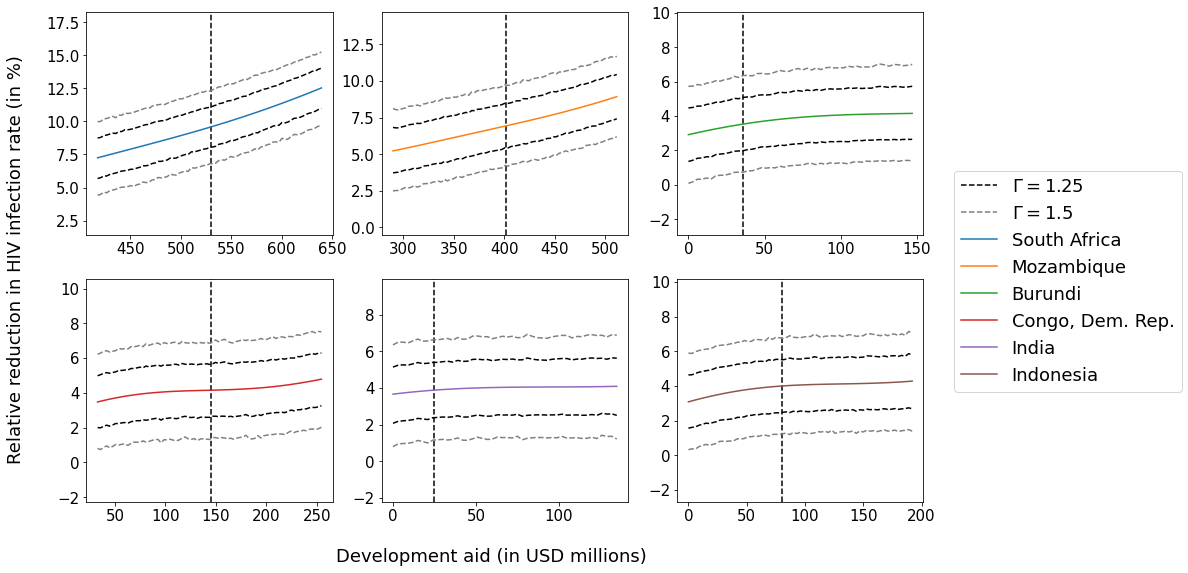

In [47]:
# Visualize causal sensitivity bounds

#Load trained model parameters
GPS_mods = np.load('plot_data/tr_var.npz')
b_coef = GPS_mods['b_coef']
sig_hat = GPS_mods['sig_hat']
a_coef = GPS_mods['a_coef']
df_baes = GPS_mods['df_bae']


# Real world - train
df_train = pd.read_csv('data/HIV_data.csv')
year = 2016
df_train = df_train[df_train['year'] == year]
df_train['hiv_cases'] = df_train['hiv_rate']*df_train['population'] # In thousands
df_train.head(5)

# Estimate residual variance on training data
# Predict factual outcomes
y_hat = np.empty((df_train.shape[0], 1))
for i, country in enumerate(df_train['country'].unique()):
    country_ind = np.where(df_train['country'] == country)[0]
    a_obs = df_train[df_train['country']==country]['hiv_aid']
    a_obs = a_obs.iloc[0]
    y_hat[i, 0] = GPS_pred(np.concatenate(([[a_obs]], df_baes[country_ind, 2:, 0]), axis=1), b_coef[:, 0:(0 + 1)],
             sig_hat[:, 0:(0 + 1)], a_coef[:, 0:(0 + 1)])

#Factual outcome
y = np.expand_dims(df_train['hiv_reduction'].to_numpy(), axis=1) * 100
residuals = y / 100 - y_hat
eps_hat = np.sum(residuals**2) / (df_train.shape[0])

# Real world - test
df = pd.read_csv('data/HIV_data.csv')
year = 2017
df = df[df['year'] == year]
df['hiv_cases'] = df['hiv_rate']*df['population'] # In thousands
df.head(5)
a_sig = np.std(df['hiv_aid'])

# Plot treatment response curves and sensitivity bounds
countries = ['South Africa', 'Mozambique', 'Burundi', 'Congo, Dem. Rep.', 'India', 'Indonesia']
gammas = torch.tensor([1.25, 1.5])

fig, axs = plt.subplots(2, 3, figsize=(15, 9))

plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
color_cycle = plt.rcParams['axes.prop_cycle']()
bound_colors = ["black", "grey"]
bound_labels = [r"$\Gamma = 1.25$", r"$\Gamma = 1.5$"]

# Country 1
country = countries[0]
a_obs = df[df['country']==country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs-a_sig, a_obs+a_sig, 3)
else:
    a = np.arange(0, a_obs+a_sig, 3)
y = np.empty(len(a))
for i in range(len(a)):
    country_ind = np.where(df['country'] == country)[0]
    y[i] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, 0]), axis=1) , b_coef[:,0:1], sig_hat[:,0:1], a_coef[:,0:1]) * 100

# Bounds
[Q_plus, Q_minus] = compute_bounds(y, eps_hat * 100 * 100, gammas)
for i in range(len(gammas)):
    gamma = gammas[i]
    # Plot bounds as dotted lines
    axs[0, 0].plot(a, Q_plus[:, i], color=bound_colors[i], linestyle='dashed', label=bound_labels[i])
    axs[0, 0].plot(a, Q_minus[:, i], color=bound_colors[i], linestyle='dashed')
axs[0, 0].plot(a, y, label=country, **next(color_cycle))
y_min = Q_minus[:, -1].min() - 3
y_max = Q_plus[:, -1].max() + 3
axs[0, 0].vlines(x=df.loc[df['country']==country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                colors='black', linestyle='dashed')
axs[0, 0].set_ylim([y_min, y_max])

# Country 2 ------------------------------------------
country = countries[1]
a_obs = df[df['country'] == country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs - a_sig, a_obs + a_sig, 3)
else:
    a = np.arange(0, a_obs + a_sig, 3)
y = np.empty(len(a))
for i in range(len(a)):
    country_ind = np.where(df['country'] == country)[0]
    y[i] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, 0]), axis=1) , b_coef[:,0:1], sig_hat[:,0:1], a_coef[:,0:1]) * 100

# Bounds
[Q_plus, Q_minus] = compute_bounds(y, eps_hat*10000, gammas)
for i in range(len(gammas)):
    gamma = gammas[i]
    # Plot bounds as dotted lines
    axs[0, 1].plot(a, Q_plus[:, i], color=bound_colors[i], linestyle='dashed')
    axs[0, 1].plot(a, Q_minus[:, i], color=bound_colors[i], linestyle='dashed')
axs[0, 1].plot(a, y, label=country, **next(color_cycle))
y_min = Q_minus[:, -1].min() - 3
y_max = Q_plus[:, -1].max() + 3
axs[0, 1].vlines(x=df.loc[df['country'] == country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                 colors='black', linestyle='dashed')
axs[0, 1].set_ylim([y_min, y_max])

# Country 3 --------------------------------------------
country = countries[2]
a_obs = df[df['country'] == country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs - a_sig, a_obs + a_sig, 3)
else:
    a = np.arange(0, a_obs + a_sig, 3)
y = np.empty(len(a))
for i in range(len(a)):
    country_ind = np.where(df['country'] == country)[0]
    y[i] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, 0]), axis=1) , b_coef[:,0:1], sig_hat[:,0:1], a_coef[:,0:1]) * 100

# Bounds
[Q_plus, Q_minus] = compute_bounds(y, eps_hat * 10000, gammas)
for i in range(len(gammas)):
    gamma = gammas[i]
    # Plot bounds as dotted lines
    axs[0, 2].plot(a, Q_plus[:, i], color=bound_colors[i], linestyle='dashed')
    axs[0, 2].plot(a, Q_minus[:, i], color=bound_colors[i], linestyle='dashed')
axs[0, 2].plot(a, y, label=country, **next(color_cycle))
y_min = Q_minus[:, -1].min() - 3
y_max = Q_plus[:, -1].max() + 3
axs[0, 2].vlines(x=df.loc[df['country'] == country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                 colors='black', linestyle='dashed')
axs[0, 2].set_ylim([y_min, y_max])

# Country 4 ------------------------------------------
country = countries[3]
a_obs = df[df['country'] == country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs - a_sig, a_obs + a_sig, 3)
else:
    a = np.arange(0, a_obs + a_sig, 3)
y = np.empty(len(a))
for i in range(len(a)):
    country_ind = np.where(df['country'] == country)[0]
    y[i] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, 0]), axis=1) , b_coef[:,0:1], sig_hat[:,0:1], a_coef[:,0:1]) * 100

# Bounds
[Q_plus, Q_minus] = compute_bounds(y, eps_hat*10000, gammas)
for i in range(len(gammas)):
    gamma = gammas[i]
    # Plot bounds as dotted lines
    axs[1, 0].plot(a, Q_plus[:, i], color=bound_colors[i], linestyle='dashed')
    axs[1, 0].plot(a, Q_minus[:, i], color=bound_colors[i], linestyle='dashed')
axs[1, 0].plot(a, y, label=country, **next(color_cycle))
y_min = Q_minus[:, -1].min() - 3
y_max = Q_plus[:, -1].max() + 3
axs[1, 0].vlines(x=df.loc[df['country'] == country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                 colors='black', linestyle='dashed')
axs[1, 0].set_ylim([y_min, y_max])

# Country 5 ------------------------------------------
country = countries[4]
a_obs = df[df['country'] == country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs - a_sig, a_obs + a_sig, 3)
else:
    a = np.arange(0, a_obs + a_sig, 3)
y = np.empty(len(a))
for i in range(len(a)):
    country_ind = np.where(df['country'] == country)[0]
    y[i] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, 0]), axis=1) , b_coef[:,0:1], sig_hat[:,0:1], a_coef[:,0:1]) * 100

# Bounds
[Q_plus, Q_minus] = compute_bounds(y, eps_hat*10000, gammas)
for i in range(len(gammas)):
    gamma = gammas[i]
    # Plot bounds as dotted lines
    axs[1, 1].plot(a, Q_plus[:, i], color=bound_colors[i], linestyle='dashed')
    axs[1, 1].plot(a, Q_minus[:, i], color=bound_colors[i], linestyle='dashed')
axs[1, 1].plot(a, y, label=country, **next(color_cycle))
y_min = Q_minus[:, -1].min() - 3
y_max = Q_plus[:, -1].max() + 3
axs[1, 1].vlines(x=df.loc[df['country'] == country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                 colors='black', linestyle='dashed')
axs[1, 1].set_ylim([y_min, y_max])

# Country 6 ------------------------------------------
country = countries[5]
a_obs = df[df['country'] == country]['hiv_aid']
a_obs = a_obs.iloc[0]
if a_obs - a_sig > 0:
    a = np.arange(a_obs - a_sig, a_obs + a_sig, 3)
else:
    a = np.arange(0, a_obs + a_sig, 3)
y = np.empty(len(a))
for i in range(len(a)):
    country_ind = np.where(df['country'] == country)[0]
    y[i] = GPS_pred(np.concatenate(([[a[i]]], df_baes[country_ind, 2:, 0]), axis=1) , b_coef[:,0:1], sig_hat[:,0:1], a_coef[:,0:1]) * 100

# Bounds
[Q_plus, Q_minus] = compute_bounds(y, eps_hat*10000, gammas)
for i in range(len(gammas)):
    gamma = gammas[i]
    # Plot bounds as dotted lines
    axs[1, 2].plot(a, Q_plus[:, i], color=bound_colors[i], linestyle='dashed')
    axs[1, 2].plot(a, Q_minus[:, i], color=bound_colors[i], linestyle='dashed')
axs[1, 2].plot(a, y, label=country, **next(color_cycle))
y_min = Q_minus[:, -1].min() - 3
y_max = Q_plus[:, -1].max() + 3
axs[1, 2].vlines(x=df.loc[df['country'] == country, 'hiv_aid'], ymin=y_min, ymax=y_max,
                 colors='black', linestyle='dashed')
axs[1, 2].set_ylim([y_min, y_max])


# Create figure
fig.text(0.5, 0.04, 'Development aid (in USD millions)', ha='center', va='center', size=18)
fig.text(0.06, 0.5, "Relative reduction in HIV infection rate (in %)", ha='center', va='center',
         rotation='vertical', size=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.92, 0.65), loc='upper left')

plt.show()

#fig.savefig("causal_sensitivity.pdf", bbox_inches='tight')

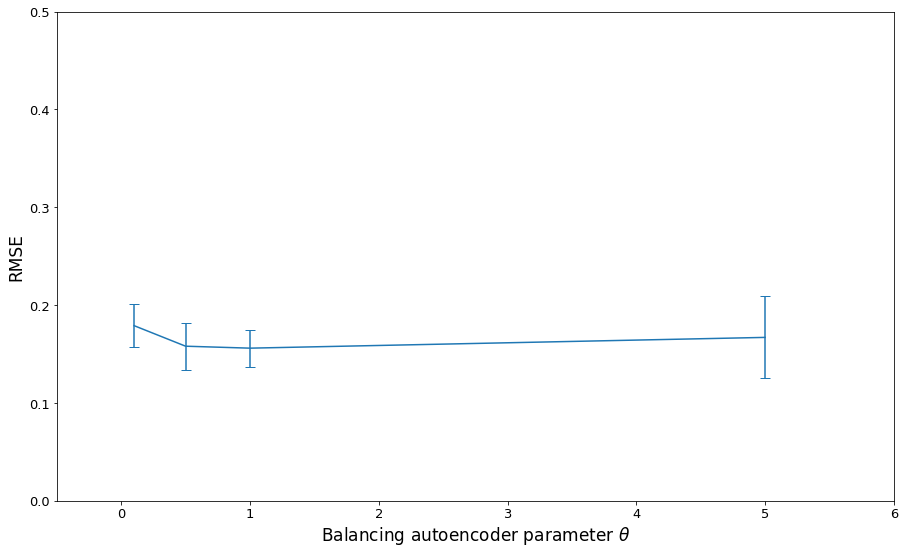

In [49]:
# Visualize Sensitivity

fig, ax = plt.subplots(1, 1)
fig.set_figheight(9)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

x = np.array([0.1, 0.5, 1, 5])
y = np.array([0.179, 0.158, 0.156, 0.167])
yerr = np.array([0.022, 0.024, 0.019, 0.042])
ax.errorbar(x, y, yerr=yerr, capsize=5, color='tab:blue')

ax.set(xlabel=r'Balancing autoencoder parameter $\theta$', ylabel="RMSE")
ax.set_xlim(-0.5, 6)
ax.set_ylim(0, 0.5)
ax.set_title("")

plt.show()

#fig.savefig("sensitivity_theta.pdf", bbox_inches='tight')

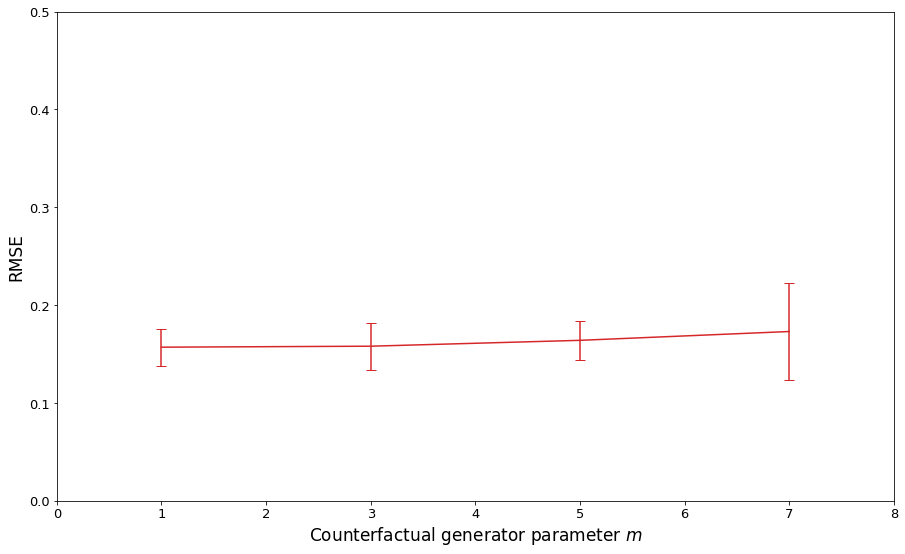

In [51]:
# Visualize Sensitivity

fig, ax = plt.subplots(1, 1)
fig.set_figheight(9)
fig.set_figwidth(15)
plt.rc('axes', titlesize=17)
plt.rc('axes', labelsize=17)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=17) 

x = np.array([1, 3, 5, 7])
y = np.array([0.157, 0.158, 0.164, 0.173])
yerr = np.array([0.019, 0.024, 0.02, 0.05])
ax.errorbar(x, y, yerr=yerr, capsize=5, color='tab:red')

ax.set_xlim(0, 8)
ax.set_ylim(0, 0.5)
ax.set(xlabel=r'Counterfactual generator parameter $m$', ylabel="RMSE")
ax.set_title("")

plt.show()

#fig.savefig("sensitivity_m.pdf", bbox_inches='tight')